In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 6280, done.
remote: Counting objects: 100% (1469/1469), done.
remote: Compressing objects: 100% (311/311), done.
remote: Total 6280 (delta 1262), reused 1336 (delta 1149), pack-reused 4811
Receiving objects: 100% (6280/6280), 2.94 GiB | 34.22 MiB/s, done.
Resolving deltas: 100% (5088/5088), done.
Updating files: 100% (505/505), done.


In [2]:
! pip install implicit

  Obtaining dependency information for implicit from https://files.pythonhosted.org/packages/cd/cc/deac70cae8cc32c9885d0cd73bc66e1b3cbea36ae7080b8c83995eaf5322/implicit-0.7.2-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 34.1 MB/s eta 0:00:00


In [3]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 238.8 kB/s eta 0:00:00


In [4]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorizationImpressions_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorizationImpressions_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorizationImpressions_Cython_Epoch.c: In functio

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps
from concurrent.futures import ThreadPoolExecutor

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/training-tuned-models/als_all.npz
/kaggle/input/training-tuned-models/__results__.html
/kaggle/input/training-tuned-models/ease_r_all.zip
/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip
/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz
/kaggle/input/training-tuned-models/als_train_validation.npz
/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/slim_recall_train_validation.zip
/kaggle/input/training-tuned-models/ease_r_train_validation.zip
/kaggle/input/training-tuned-models/__notebook__.ipynb
/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/ials_train_validation.zip
/kaggle/input/training-tuned-models/mult_vae_2_all.zip
/kaggle/input/training-tuned-models/ease_r_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/__output__.json
/kaggle/input/training-tuned-models/ials_all.zip
/kaggle/input/training-tun

In [6]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [7]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender, SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender, PureSVDItemRecommender, ScaledPureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.NonPersonalizedRecommender import TopPop

from Recommenders.Hybrid.LinearCombinationRecommender import LinearCombinationRecommender
from Data_manager.CrossValidationSplitter import CrossValidationSplitter
from Recommenders.MatrixFactorization.ALSImplicitRecommender import ALSImplicitRecommender
from Recommenders.GraphBased.HHPRecommender import HHPRecommender
from Recommenders.GraphBased.TwoWayRankAggregationRecommender import TwoWayRankAggregationRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [8]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [9]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [10]:
config = {
    'tune_parameters': True,
    'database_path': '/kaggle/working/tuning_normalized_no_slim.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': True,
    'save_github': True
}

In [11]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [12]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [13]:
URM_train, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_validation, URM_test = split_train_in_two_percentage_global_sample(URM_test_complete, train_percentage = 0.8)

In [14]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_item.json', 'r') as params_file:
    params_item_knn = json.load(params_file)
params_item_knn

{'topK': 14,
 'shrink': 25,
 'similarity': 'tversky',
 'tversky_alpha': 0.18163095712123836,
 'tversky_beta': 1.8529812241698465}

In [15]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_RP3.json', 'r') as params_file:
    params_rp3 = json.load(params_file)
params_rp3

{'alpha': 0.3408516511081212, 'beta': 0.1447198697205665, 'topK': 32}

In [16]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_user.json', 'r') as params_file:
    params_user_knn = json.load(params_file)
params_user_knn

{'topK': 498,
 'shrink': 0,
 'similarity': 'asymmetric',
 'asymmetric_alpha': 0.39792525383867455}

In [17]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_alpha.json', 'r') as params_file:
    params_p3alpha = json.load(params_file)
params_p3alpha

{'normalize_similarity': 'True',
 'implicit': 'True',
 'alpha': 0.29354071531607107,
 'topK': 49}

In [18]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/pure_svd_params.json', 'r') as params_file:
    params_pure_svd = json.load(params_file)
params_pure_svd

{'factors': 30}

In [19]:
# with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_item.json', 'r') as params_file:
#     params_pure_svd_item = json.load(params_file)
params_pure_svd_item = {"topK": 43, "num_factors": 171}

In [20]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_scaled.json', 'r') as params_file:
    params_scaled = json.load(params_file)
params_scaled

{'num_factors': 179,
 'scaling_items': 5.3298425368534826e-05,
 'scaling_users': 0.2791990262721904}

In [21]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hhp.json', 'r') as params_file:
    params_hhp = json.load(params_file)
params_hhp

{'hybrid_lambda': 0.8450256587797654, 'topK': 61}

In [22]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_twra.json', 'r') as params_file:
    params = json.load(params_file)

params_twra = {
    'base_f_algorithm': params['base_f_algorithm'], 
    'base_b_algorithm': params['base_b_algorithm'], 
    'convex_lambda': params['convex_lambda'],
}

if params['base_f_algorithm'] == 'p3':
    params_twra['f_params'] = {
        'topK': params['f_p3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_f_algorithm'] == 'p3alpha':
    params_twra['f_params'] = {
        'alpha': params['f_p3a_alpha'],
        'topK': params['f_p3a_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_f_algorithm'] == 'rp3beta':
    params_twra['f_params'] = {
        'alpha': params['f_rp3_alpha'],
        'beta': params['f_rp3_beta'],
        'topK': params['f_rp3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
else:
    params_twra['f_params'] = {
        'hybrid_lambda': params['f_hhp_hybrid_lambda'],
        'topK': params['f_hhp_topK'],
    }

if params['base_b_algorithm'] == 'p3':
    params_twra['b_params'] = {
        'topK': params['b_p3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_b_algorithm'] == 'p3alpha':
    params_twra['b_params'] = {
        'alpha': params['b_p3a_alpha'],
        'topK': params['b_p3a_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_b_algorithm'] == 'rp3beta':
    params_twra['b_params'] = {
        'alpha': params['b_rp3_alpha'],
        'beta': params['b_rp3_beta'],
        'topK': params['b_rp3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
else:
    params_twra['b_params'] = {
        'hybrid_lambda': params['b_hhp_hybrid_lambda'],
        'topK': params['b_hhp_topK'],
    }

In [23]:
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip', 
    '/kaggle/working/ials_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_train_validation.zip', 
    '/kaggle/working/ials_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_all.zip', 
    '/kaggle/working/ials_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz', 
    '/kaggle/working/als_xgboost_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_train_validation.npz', 
    '/kaggle/working/als_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_all.npz', 
    '/kaggle/working/als_all.npz', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip', 
    '/kaggle/working/mult_vae_2_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip', 
    '/kaggle/working/mult_vae_2_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_all.zip', 
    '/kaggle/working/mult_vae_2_all.zip', 
)

'/kaggle/working/mult_vae_2_all.zip'

In [24]:
from numpy import linalg as LA


class NormalizedScoresLinearCombinationRecommender(BaseRecommender):
    def __init__(self, URM_train, recommenders: list[BaseRecommender], weights: list[float], normalize=None):
        super(NormalizedScoresLinearCombinationRecommender, self).__init__(URM_train)
        self.recommenders = recommenders
        weights_sum = sum(weights)
        self.weights = [w / weights_sum for w in weights]
        if normalize is not None and normalize not in ['l1', 'l2', 'linf', 'lminusinf']:
            raise ValueError('Normalization term not recognized')
        self.normalize = normalize
        
    def _compute_item_score(self, user_id_array, items_to_compute=None):
        scores = np.zeros((len(user_id_array), self.n_items))
        for recommender, w in zip(self.recommenders, self.weights):
            recommender_scores = recommender._compute_item_score(user_id_array, items_to_compute)
            scores += self._normalize_scores(recommender_scores) * w
        return scores
    
    def _normalize_scores(self, scores):       
        if self.normalize is None:
            return scores
        elif self.normalize == 'l1':
            return scores / (LA.norm(scores, 1, axis=1, keepdims=True) + 1e-6)
        elif self.normalize == 'l2':
            return scores / (LA.norm(scores, 2, axis=1, keepdims=True) + 1e-6)
        elif self.normalize == 'linf':
            return scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
        else:
            return scores / (LA.norm(scores, -np.inf, axis=1, keepdims=True) + 1e-6)

In [25]:
recommender_item = ItemKNNCFRecommender(URM_train)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_xgboost_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_xgboost_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_xgboost_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_xgboost_train_validation.zip')

recommender_ials = IALSRecommender(URM_train)
recommender_ials.load_model('/kaggle/working/', 'ials_xgboost_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_xgboost_train_validation')

recommender_hhp = HHPRecommender(URM_train)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_train)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_train)
# recommender_als.load_model('/kaggle/working/', 'als_xgboost_train_validation.npz')

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 22347 (100.0%), 6914.00 column/sec. Elapsed time 3.23 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 5732.58 column/sec. Elapsed time 2.27 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 4301.98 column/sec. Elapsed time 5.19 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 4460.06 column/sec. Elapsed time 5.01 sec
PureSVDRecommender: URM Detected 627 ( 4.8%) users with no inter

In [26]:
weights = [0.4, 0.4, 0.2]
linear_combinator = LinearCombinationRecommender(URM_train, [recommender_item, recommender_rp3, recommender_p3a], weights)
normalized_linear_comb = NormalizedScoresLinearCombinationRecommender(
    URM_train,
    recommenders=[recommender_item, recommender_rp3, recommender_p3a],
    weights=weights,
    normalize='linf'
)
evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])

print('Linear Combinator (Item knn, p3alpha, rp3)')
result_df, _ = evaluator.evaluateRecommender(linear_combinator)
display(result_df)
print('Normalized Linear Combinator (Item knn, p3alpha, rp3)')
result_df, _ = evaluator.evaluateRecommender(normalized_linear_comb)
display(result_df)
print('Item KNN')
result_df, _ = evaluator.evaluateRecommender(recommender_item)
display(result_df)
print('RP3 beta')
result_df, _ = evaluator.evaluateRecommender(recommender_rp3)
display(result_df)
print('P3 alpha')
result_df, _ = evaluator.evaluateRecommender(recommender_p3a)
display(result_df)
print('User KNN')
result_df, _ = evaluator.evaluateRecommender(recommender_user)
display(result_df)
print('NMF')
result_df, _ = evaluator.evaluateRecommender(recommender_nmf)
display(result_df)
print('Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_pure_svd)
display(result_df)
print('Scaled Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_scaled_svd)
display(result_df)
print('Item Pure SVD')
result_df, _ = evaluator.evaluateRecommender(recommender_pure_svd_item)
display(result_df)
print('SLIM BPR')
result_df, _ = evaluator.evaluateRecommender(recommender_slim_bpr)
display(result_df)
print('EASE R')
result_df, _ = evaluator.evaluateRecommender(recommender_ease_r)
display(result_df)
print('IALS')
result_df, _ = evaluator.evaluateRecommender(recommender_ials)
display(result_df)

Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
Linear Combinator (Item knn, p3alpha, rp3)
EvaluatorHoldout: Processed 10456 (100.0%) in 8.65 sec. Users per second: 1208


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.096538,0.165157,0.138974,0.049938,0.085155,0.27383,0.152219,0.113933,0.517215,0.36479,...,0.802826,0.415233,0.802826,0.079362,10.588395,0.998316,0.22899,0.815689,1.562376,0.307388


Normalized Linear Combinator (Item knn, p3alpha, rp3)
EvaluatorHoldout: Processed 10456 (100.0%) in 9.95 sec. Users per second: 1050


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.096691,0.165282,0.139053,0.050144,0.08557,0.275452,0.152829,0.114066,0.519223,0.366796,...,0.802826,0.416846,0.802826,0.083914,10.708457,0.998539,0.242126,0.824938,1.446918,0.310078


Item KNN
EvaluatorHoldout: Processed 10456 (100.0%) in 5.30 sec. Users per second: 1974


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.09451,0.161146,0.135378,0.048719,0.082976,0.267977,0.148683,0.111312,0.511572,0.356662,...,0.802826,0.410703,0.802826,0.066309,10.283111,0.997789,0.191329,0.792171,1.734564,0.30426


RP3 beta
EvaluatorHoldout: Processed 10456 (100.0%) in 5.34 sec. Users per second: 1957


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.095008,0.162969,0.137154,0.04916,0.084325,0.273626,0.150836,0.112255,0.517598,0.361989,...,0.802826,0.415541,0.802826,0.095265,10.876609,0.998685,0.274877,0.837892,1.348527,0.315394


P3 alpha
EvaluatorHoldout: Processed 10456 (100.0%) in 5.34 sec. Users per second: 1959


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.092358,0.15618,0.130929,0.047745,0.081353,0.267656,0.146022,0.108312,0.507269,0.352674,...,0.802826,0.407248,0.802826,0.069984,10.530815,0.998437,0.201933,0.811253,1.356167,0.311674


User KNN
EvaluatorHoldout: Processed 10456 (100.0%) in 9.28 sec. Users per second: 1127


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.07172,0.128756,0.110157,0.035281,0.062836,0.223137,0.116955,0.086877,0.446251,0.278756,...,0.802826,0.358262,0.802826,0.012513,7.842357,0.986392,0.036106,0.604145,3.565726,0.26052


NMF
EvaluatorHoldout: Processed 10456 (100.0%) in 7.72 sec. Users per second: 1354


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.054256,0.087589,0.071553,0.027347,0.044101,0.177126,0.084951,0.061715,0.34803,0.218582,...,0.802826,0.279407,0.802826,0.01928,9.183409,0.997939,0.055631,0.707454,1.285937,0.292166


Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 7.33 sec. Users per second: 1426


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.058655,0.100586,0.084556,0.029356,0.049861,0.191304,0.094675,0.069264,0.379112,0.235505,...,0.802826,0.304361,0.802826,0.006201,7.529534,0.992933,0.017892,0.580046,2.618313,0.263304


Scaled Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 8.88 sec. Users per second: 1178


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.064097,0.109815,0.092927,0.032531,0.055816,0.210252,0.104525,0.075865,0.406561,0.259989,...,0.802826,0.326397,0.802826,0.014436,8.746799,0.996979,0.041653,0.673819,1.928255,0.276719


Item Pure SVD
EvaluatorHoldout: Processed 10456 (100.0%) in 10.76 sec. Users per second: 972


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.065541,0.110029,0.091588,0.033231,0.054743,0.208886,0.103893,0.076406,0.405222,0.261456,...,0.802826,0.325322,0.802826,0.018829,9.102948,0.997654,0.05433,0.701256,1.415577,0.290871


SLIM BPR
EvaluatorHoldout: Processed 10456 (100.0%) in 6.62 sec. Users per second: 1579


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.063801,0.112575,0.095855,0.031484,0.056143,0.205053,0.104647,0.07661,0.410578,0.252495,...,0.802826,0.329622,0.802826,0.026347,8.799203,0.994034,0.076023,0.677856,2.707652,0.2752


EASE R
EvaluatorHoldout: Processed 10456 (100.0%) in 9.21 sec. Users per second: 1135


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.08663,0.148643,0.125317,0.045027,0.077438,0.261421,0.139657,0.102443,0.491297,0.339833,...,0.802826,0.394426,0.802826,0.036834,9.788176,0.997836,0.106282,0.754043,1.866956,0.288687


IALS
EvaluatorHoldout: Processed 10456 (100.0%) in 10.18 sec. Users per second: 1027


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.074264,0.128897,0.109507,0.037004,0.06347,0.22736,0.11856,0.088506,0.447877,0.287953,...,0.802826,0.359567,0.802826,0.025371,9.557886,0.998317,0.073204,0.736302,1.701875,0.287446


In [27]:
weights = [0.3, 0.3, 0.2, 0.05, 0.1, 0.005, 0.001, 0.001]
recommenders = [recommender_item, recommender_rp3, recommender_p3a, recommender_ials, recommender_ease_r, recommender_user, recommender_nmf, recommender_slim_bpr]
linear_combinator = LinearCombinationRecommender(URM_train, recommenders, weights)

l1_normalized_linear_comb = NormalizedScoresLinearCombinationRecommender(
    URM_train,
    recommenders=recommenders,
    weights=weights,
    normalize='l1'
)

l2_normalized_linear_comb = NormalizedScoresLinearCombinationRecommender(
    URM_train,
    recommenders=recommenders,
    weights=weights,
    normalize='l2'
)

linf_normalized_linear_comb = NormalizedScoresLinearCombinationRecommender(
    URM_train,
    recommenders=recommenders,
    weights=weights,
    normalize='linf'
)

lminusinf_normalized_linear_comb = NormalizedScoresLinearCombinationRecommender(
    URM_train,
    recommenders=recommenders,
    weights=weights,
    normalize='lminusinf'
)

evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
print('No Normalization')
result_df, _ = evaluator.evaluateRecommender(linear_combinator)
display(result_df)
print('L1 Norm')
result_df, _ = evaluator.evaluateRecommender(l1_normalized_linear_comb)
display(result_df)
print('L2 Norm')
result_df, _ = evaluator.evaluateRecommender(l2_normalized_linear_comb)
display(result_df)
print('L_infinity Norm')
result_df, _ = evaluator.evaluateRecommender(linf_normalized_linear_comb)
display(result_df)
print('L_minus_infinity Norm')
result_df, _ = evaluator.evaluateRecommender(lminusinf_normalized_linear_comb)
display(result_df)

Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
No Normalization
EvaluatorHoldout: Processed 10456 (100.0%) in 23.61 sec. Users per second: 443


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.097743,0.169232,0.142941,0.050424,0.086573,0.276759,0.154759,0.116098,0.523145,0.368705,...,0.802826,0.419994,0.802826,0.05994,10.15296,0.997439,0.172951,0.782145,1.898103,0.296887


L1 Norm
EvaluatorHoldout: Processed 10456 (100.0%) in 27.11 sec. Users per second: 386


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.096863,0.165927,0.139626,0.050106,0.085453,0.275439,0.152878,0.114378,0.519702,0.36651,...,0.802826,0.41723,0.802826,0.08245,10.691253,0.998535,0.237902,0.823613,1.482494,0.307585


L2 Norm
EvaluatorHoldout: Processed 10456 (100.0%) in 26.34 sec. Users per second: 397


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.096959,0.166362,0.140084,0.050279,0.085981,0.277022,0.153565,0.114599,0.520849,0.368294,...,0.802826,0.418151,0.802826,0.078685,10.641817,0.998517,0.227037,0.819804,1.4905,0.30642


L_infinity Norm
EvaluatorHoldout: Processed 10456 (100.0%) in 27.28 sec. Users per second: 383


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.097064,0.166332,0.139994,0.050383,0.086203,0.277835,0.153838,0.114642,0.520562,0.369152,...,0.802826,0.417921,0.802826,0.077505,10.627012,0.998516,0.223633,0.818664,1.491513,0.306051


L_minus_infinity Norm
EvaluatorHoldout: Processed 10456 (100.0%) in 26.30 sec. Users per second: 398


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.097743,0.169232,0.142941,0.050424,0.086573,0.276759,0.154759,0.116098,0.523145,0.368705,...,0.802826,0.419994,0.802826,0.05994,10.15296,0.997439,0.172951,0.782145,1.898103,0.296887


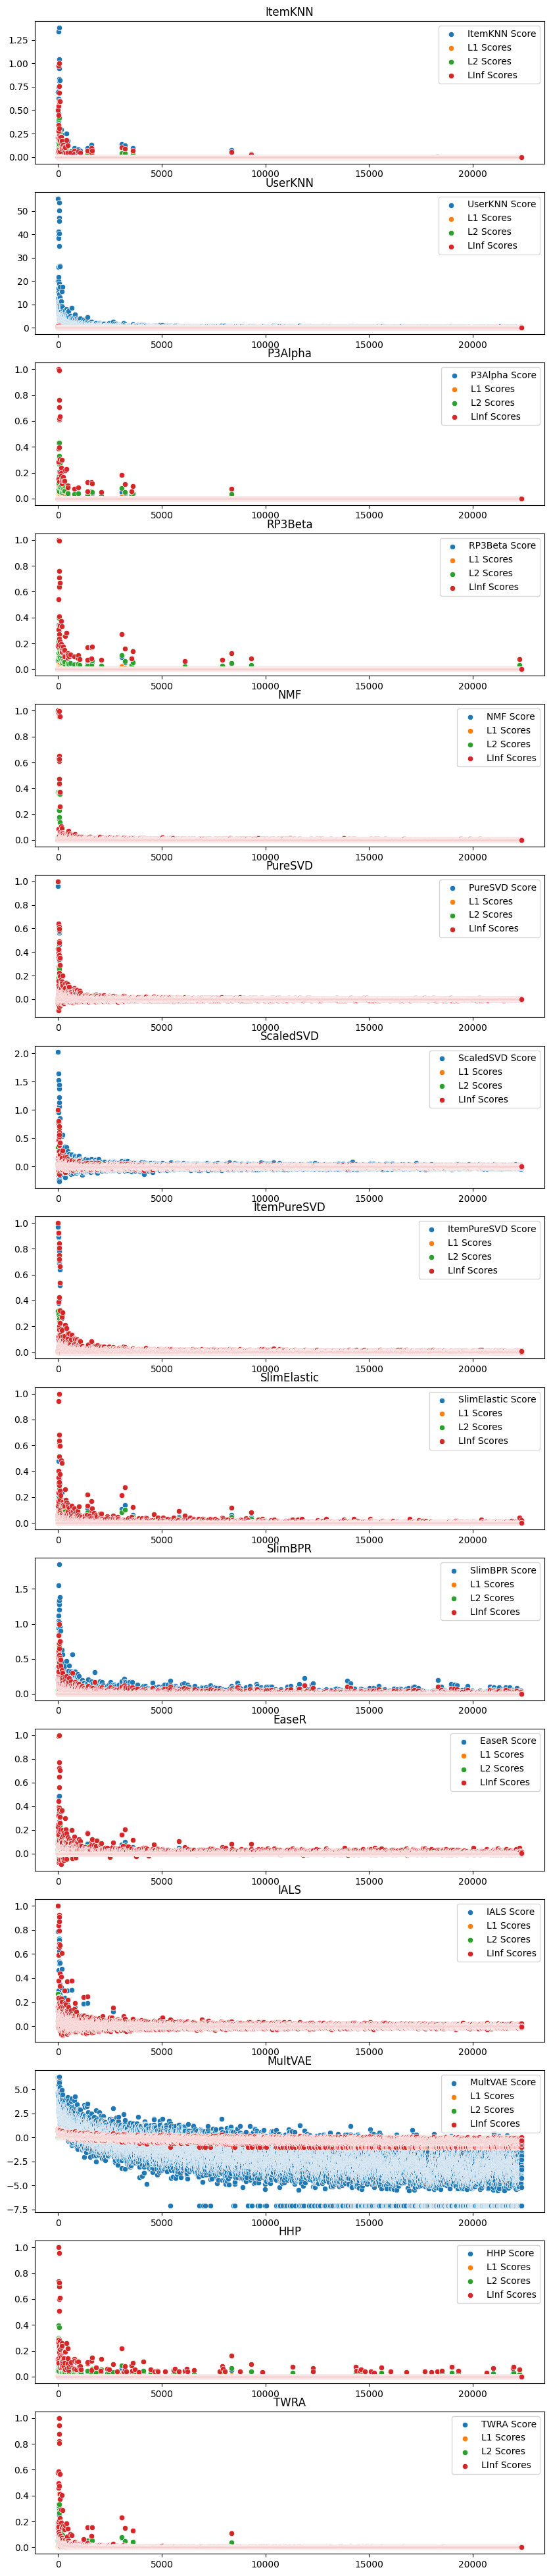

In [28]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

fig, axes = plt.subplots(len(recommender_object_dict.keys()), 1, figsize=(10, 50))

for i, (label, recommender) in enumerate(recommender_object_dict.items()):
    scores = recommender._compute_item_score([500]).flatten()
    l1_scores = scores / LA.norm(scores, 1)
    l2_scores = scores / LA.norm(scores, 2)
    linf_scores = scores / LA.norm(scores, np.inf)
    # lminusinf_scores = scores / LA.norm(scores, -np.inf)
    
    axes[i].set_title(label)
    sns.scatterplot(data=scores, ax=axes[i])
    sns.scatterplot(data=l1_scores, ax=axes[i])
    sns.scatterplot(data=l2_scores, ax=axes[i])
    sns.scatterplot(data=linf_scores, ax=axes[i])
    # sns.scatterplot(data=lminusinf_scores, ax=axes[i])
    
    axes[i].legend([f"{label} Score", "L1 Scores", "L2 Scores", "LInf Scores"])

In [29]:
evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])

def objective(trial):  
    
    weights = [
        trial.suggest_float('ItemKNN', 1e-3, 1, log=True),
        trial.suggest_float('UserKNN', 1e-5, 1, log=True),
        trial.suggest_float('P3Alpha', 1e-3, 1, log=True),
        trial.suggest_float('RP3Beta', 1e-3, 1, log=True),
        trial.suggest_float('NMF', 1e-6, 0.1, log=True),
        trial.suggest_float('ScaledSVD', 1e-6, 0.1, log=True),
        trial.suggest_float('ItemPureSVD', 1e-6, 0.1, log=True),
        trial.suggest_float('SlimElastic', 1e-2, 1, log=True),
        trial.suggest_float('SlimBPR', 1e-6, 0.1, log=True),
        trial.suggest_float('EaseR', 1e-3, 1, log=True),
        trial.suggest_float('IALS', 1e-4, 1, log=True),
        trial.suggest_float('MultVAE', 1e-4, 1, log=True),
        trial.suggest_float('HHP', 1e-4, 1, log=True),
        trial.suggest_float('TWRA', 5e-3, 1, log=True),
    ]
    
    normalize = trial.suggest_categorical('normalize', ['l1', 'l2', 'linf'])
    
    recommenders = [
        recommender_item, recommender_user, recommender_p3a, recommender_rp3, recommender_nmf,
        recommender_scaled_svd, recommender_pure_svd_item, recommender_slim, recommender_slim_bpr,
        recommender_ease_r, recommender_ials, recommender_vae, recommender_hhp, recommender_twra
    ]
    
    normalized_linear_comb = NormalizedScoresLinearCombinationRecommender(
        URM_train,
        recommenders=recommenders,
        weights=weights,
        normalize=normalize
    )
    evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])
    result_df, _ = evaluator.evaluateRecommender(normalized_linear_comb)

    return result_df.loc[10, 'MAP']

EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions


In [30]:
try:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/tuning_normalized_no_cv.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass

In [31]:
if config['tune_parameters']:
    study = optuna.create_study(direction='maximize', study_name='tuning', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective, n_trials=150)

[I 2023-12-28 13:34:21,466] A new study created in RDB with name: tuning


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 2.00 min. Users per second: 87


[I 2023-12-28 13:36:21,935] Trial 0 finished with value: 0.05109659449727414 and parameters: {'ItemKNN': 0.050626764788068566, 'UserKNN': 0.0008740514494274228, 'P3Alpha': 0.07455483982864268, 'RP3Beta': 0.04298374395914004, 'NMF': 2.9208390775207485e-06, 'ScaledSVD': 0.0010520792579089802, 'ItemPureSVD': 5.1695397037966624e-05, 'SlimElastic': 0.17192807356036174, 'SlimBPR': 3.813948880270343e-05, 'EaseR': 0.016626986561494306, 'IALS': 0.008578361538747192, 'MultVAE': 0.2967428552518386, 'HHP': 0.46113908879954363, 'TWRA': 0.9709999349594454, 'normalize': 'linf'}. Best is trial 0 with value: 0.05109659449727414.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.76 min. Users per second: 99


[I 2023-12-28 13:38:08,032] Trial 1 finished with value: 0.050863941566170405 and parameters: {'ItemKNN': 0.4166640375503162, 'UserKNN': 0.13586639172718915, 'P3Alpha': 0.18090279761281192, 'RP3Beta': 0.4461194242250655, 'NMF': 3.303518239798768e-05, 'ScaledSVD': 0.00011547805719350725, 'ItemPureSVD': 3.4475537844180187e-06, 'SlimElastic': 0.023029393778100732, 'SlimBPR': 0.003607404475690454, 'EaseR': 0.509910525236939, 'IALS': 0.0004113869132279689, 'MultVAE': 0.0035812673448057486, 'HHP': 0.01303719225485485, 'TWRA': 0.9444143271853681, 'normalize': 'l1'}. Best is trial 0 with value: 0.05109659449727414.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.76 min. Users per second: 99


[I 2023-12-28 13:39:53,991] Trial 2 finished with value: 0.050468698764893 and parameters: {'ItemKNN': 0.003013252024607228, 'UserKNN': 0.019107107284263063, 'P3Alpha': 0.013421264790900797, 'RP3Beta': 0.04854093301173467, 'NMF': 0.004389109173870278, 'ScaledSVD': 0.007807668105258348, 'ItemPureSVD': 0.0020349805030893966, 'SlimElastic': 0.01734771598052495, 'SlimBPR': 1.5524597501683085e-05, 'EaseR': 0.4062891371667654, 'IALS': 0.048818464057467086, 'MultVAE': 0.1131238391341905, 'HHP': 0.07679251610792794, 'TWRA': 0.11743081661188434, 'normalize': 'l1'}. Best is trial 0 with value: 0.05109659449727414.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.78 min. Users per second: 98


[I 2023-12-28 13:41:40,962] Trial 3 finished with value: 0.049185498415127926 and parameters: {'ItemKNN': 0.002041876425778432, 'UserKNN': 0.00023876579215862943, 'P3Alpha': 0.002705813182773136, 'RP3Beta': 0.03163978502861773, 'NMF': 0.009202751849589644, 'ScaledSVD': 9.500741489729483e-05, 'ItemPureSVD': 0.049678073668790075, 'SlimElastic': 0.033777016694570415, 'SlimBPR': 0.0020353044464803023, 'EaseR': 0.0023687297614987954, 'IALS': 0.0014407969034983539, 'MultVAE': 0.0006769384926863329, 'HHP': 0.00042196626829305224, 'TWRA': 0.015366024268778299, 'normalize': 'linf'}. Best is trial 0 with value: 0.05109659449727414.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.76 min. Users per second: 99


[I 2023-12-28 13:43:26,924] Trial 4 finished with value: 0.05024431555968524 and parameters: {'ItemKNN': 0.07536766384690266, 'UserKNN': 0.000863017789567467, 'P3Alpha': 0.2526150280130194, 'RP3Beta': 0.08124586793342109, 'NMF': 0.010902693352300225, 'ScaledSVD': 0.0007693941386274469, 'ItemPureSVD': 5.3388642885142e-06, 'SlimElastic': 0.010368315805554876, 'SlimBPR': 0.0008108693597223537, 'EaseR': 0.47024960321946796, 'IALS': 0.0036881926452033173, 'MultVAE': 0.0015423051114085674, 'HHP': 0.0006843072631682171, 'TWRA': 0.20973184250168436, 'normalize': 'linf'}. Best is trial 0 with value: 0.05109659449727414.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.92 min. Users per second: 91


[I 2023-12-28 13:45:22,556] Trial 5 finished with value: 0.04708507912218767 and parameters: {'ItemKNN': 0.019283539219732783, 'UserKNN': 0.0001262048581030988, 'P3Alpha': 0.004928284044401591, 'RP3Beta': 0.008599213378323187, 'NMF': 4.316567165993819e-06, 'ScaledSVD': 0.06979430981090694, 'ItemPureSVD': 0.018365718045006262, 'SlimElastic': 0.04209123815199518, 'SlimBPR': 0.01600583714908088, 'EaseR': 0.3190531106036895, 'IALS': 0.24449982365950151, 'MultVAE': 0.06669549759609746, 'HHP': 0.0037918578905960895, 'TWRA': 0.026457378412192162, 'normalize': 'l2'}. Best is trial 0 with value: 0.05109659449727414.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 2.07 min. Users per second: 84


[I 2023-12-28 13:47:27,112] Trial 6 finished with value: 0.050672751120341704 and parameters: {'ItemKNN': 0.34215015504449625, 'UserKNN': 0.007931181003781977, 'P3Alpha': 0.02205877804802138, 'RP3Beta': 0.007515081265330886, 'NMF': 1.909211762064901e-06, 'ScaledSVD': 3.023126814817365e-05, 'ItemPureSVD': 0.00997246919285387, 'SlimElastic': 0.011249430028851357, 'SlimBPR': 4.842314946911911e-05, 'EaseR': 0.3655737424673859, 'IALS': 0.021599535290941274, 'MultVAE': 0.0037397104854964064, 'HHP': 0.0007247870444510202, 'TWRA': 0.39780323711971016, 'normalize': 'l1'}. Best is trial 0 with value: 0.05109659449727414.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.75 min. Users per second: 100


[I 2023-12-28 13:49:12,333] Trial 7 finished with value: 0.05033022734725164 and parameters: {'ItemKNN': 0.016649240580305275, 'UserKNN': 0.001412786821895163, 'P3Alpha': 0.17629430775366636, 'RP3Beta': 0.03352093569495029, 'NMF': 0.00019809328011596115, 'ScaledSVD': 0.0941608548585374, 'ItemPureSVD': 0.019869678996751166, 'SlimElastic': 0.013836590644303837, 'SlimBPR': 0.00013594602412634585, 'EaseR': 0.016301749873636237, 'IALS': 0.00024518404723999145, 'MultVAE': 0.0005312184372540647, 'HHP': 0.09838966939003291, 'TWRA': 0.6324561178523346, 'normalize': 'linf'}. Best is trial 0 with value: 0.05109659449727414.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.74 min. Users per second: 100


[I 2023-12-28 13:50:57,172] Trial 8 finished with value: 0.04802342165506931 and parameters: {'ItemKNN': 0.0016637462418749329, 'UserKNN': 0.08481611018481194, 'P3Alpha': 0.0033774444098631094, 'RP3Beta': 0.0011361062308607747, 'NMF': 0.00025323642531112806, 'ScaledSVD': 1.4697868548877998e-05, 'ItemPureSVD': 2.1678962722876605e-06, 'SlimElastic': 0.0214653201848817, 'SlimBPR': 0.0007863072447045654, 'EaseR': 0.025117578160013827, 'IALS': 0.06269361496054322, 'MultVAE': 0.010217049105487824, 'HHP': 0.4461227385145369, 'TWRA': 0.13424028971511381, 'normalize': 'l2'}. Best is trial 0 with value: 0.05109659449727414.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.74 min. Users per second: 100


[I 2023-12-28 13:52:42,052] Trial 9 finished with value: 0.050971838907713556 and parameters: {'ItemKNN': 0.9618065498218775, 'UserKNN': 0.24613677676482537, 'P3Alpha': 0.004560835370077546, 'RP3Beta': 0.001019272571238802, 'NMF': 0.006142900610693, 'ScaledSVD': 2.264251502444898e-05, 'ItemPureSVD': 8.57235053510847e-06, 'SlimElastic': 0.41253208010112963, 'SlimBPR': 1.144697206340692e-06, 'EaseR': 0.04257739377578339, 'IALS': 0.0005541928139041207, 'MultVAE': 0.00013614120623463887, 'HHP': 0.001146673057316407, 'TWRA': 0.7590337967857286, 'normalize': 'l2'}. Best is trial 0 with value: 0.05109659449727414.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.71 min. Users per second: 102


[I 2023-12-28 13:54:25,274] Trial 10 finished with value: 0.04994694699481485 and parameters: {'ItemKNN': 0.05679269063154979, 'UserKNN': 1.669179316198162e-05, 'P3Alpha': 0.9668174485145309, 'RP3Beta': 0.9626326443560702, 'NMF': 1.190422471379082e-06, 'ScaledSVD': 1.70337344595467e-06, 'ItemPureSVD': 7.930489272839393e-05, 'SlimElastic': 0.17470477690200964, 'SlimBPR': 0.09161325334657312, 'EaseR': 0.0014712410570025091, 'IALS': 0.004700356647340929, 'MultVAE': 0.6940416404312642, 'HHP': 0.78683224875216, 'TWRA': 0.04687471736171367, 'normalize': 'linf'}. Best is trial 0 with value: 0.05109659449727414.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.75 min. Users per second: 100


[I 2023-12-28 13:56:10,547] Trial 11 finished with value: 0.05122350575654956 and parameters: {'ItemKNN': 0.6625818271413091, 'UserKNN': 0.5058965635391451, 'P3Alpha': 0.0014505751466517194, 'RP3Beta': 0.0010370323078748949, 'NMF': 0.0782760660501463, 'ScaledSVD': 0.00075780098649302, 'ItemPureSVD': 4.036853024657245e-05, 'SlimElastic': 0.5825909795308172, 'SlimBPR': 1.4458227666175933e-06, 'EaseR': 0.05487184770662246, 'IALS': 0.00012304147731410543, 'MultVAE': 0.00010739497716260948, 'HHP': 0.00011094752438821995, 'TWRA': 0.9564444778632427, 'normalize': 'l2'}. Best is trial 11 with value: 0.05122350575654956.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 2.10 min. Users per second: 83


[I 2023-12-28 13:58:16,839] Trial 12 finished with value: 0.049930779471952624 and parameters: {'ItemKNN': 0.15102606723016307, 'UserKNN': 0.657469095996379, 'P3Alpha': 0.0016523437200081036, 'RP3Beta': 0.004278099662204803, 'NMF': 0.0012057352240073958, 'ScaledSVD': 0.0012196619546621771, 'ItemPureSVD': 8.873426438032896e-05, 'SlimElastic': 0.828805201558478, 'SlimBPR': 3.715269585911208e-06, 'EaseR': 0.06795291742753153, 'IALS': 0.0001989014766103663, 'MultVAE': 0.00014003289184019648, 'HHP': 0.00021051573714344943, 'TWRA': 0.31669240328606435, 'normalize': 'l2'}. Best is trial 11 with value: 0.05122350575654956.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.76 min. Users per second: 99


[I 2023-12-28 14:00:02,914] Trial 13 finished with value: 0.050880363366974525 and parameters: {'ItemKNN': 0.807458944204747, 'UserKNN': 0.024125654346536452, 'P3Alpha': 0.046606476955205915, 'RP3Beta': 0.11409103907523233, 'NMF': 0.0806384850907244, 'ScaledSVD': 0.0027378554171562123, 'ItemPureSVD': 4.265898763451763e-05, 'SlimElastic': 0.14755821891568283, 'SlimBPR': 1.1672096803054848e-05, 'EaseR': 0.010030520922532716, 'IALS': 0.0015189508002065274, 'MultVAE': 0.019063843689387554, 'HHP': 0.00013948901109328904, 'TWRA': 0.3916572932082999, 'normalize': 'linf'}. Best is trial 11 with value: 0.05122350575654956.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.75 min. Users per second: 100


[I 2023-12-28 14:01:48,340] Trial 14 finished with value: 0.050755399041790175 and parameters: {'ItemKNN': 0.17450605603693037, 'UserKNN': 0.004529869051809893, 'P3Alpha': 0.0011656949889292446, 'RP3Beta': 0.0141353744414736, 'NMF': 2.1145936920209186e-05, 'ScaledSVD': 0.0006292034637851215, 'ItemPureSVD': 0.00045041360987075577, 'SlimElastic': 0.35128889766203936, 'SlimBPR': 2.319006023024299e-06, 'EaseR': 0.06590607711314754, 'IALS': 0.7617801429138603, 'MultVAE': 0.9849664646711631, 'HHP': 0.00010492012908071905, 'TWRA': 0.9430459916498677, 'normalize': 'l2'}. Best is trial 11 with value: 0.05122350575654956.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.77 min. Users per second: 99


[I 2023-12-28 14:03:34,780] Trial 15 finished with value: 0.049180336952430154 and parameters: {'ItemKNN': 0.010533282305440077, 'UserKNN': 0.036265276887265774, 'P3Alpha': 0.009783202396246036, 'RP3Beta': 0.004312192132351259, 'NMF': 0.09511258591463649, 'ScaledSVD': 0.006628530582852269, 'ItemPureSVD': 2.287903594611115e-05, 'SlimElastic': 0.07205666097799172, 'SlimBPR': 9.824401633351422e-05, 'EaseR': 0.005012443514586487, 'IALS': 0.00011367461559844144, 'MultVAE': 0.025591027381842005, 'HHP': 0.00402240412493908, 'TWRA': 0.07700681288366269, 'normalize': 'linf'}. Best is trial 11 with value: 0.05122350575654956.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.79 min. Users per second: 97


[I 2023-12-28 14:05:22,764] Trial 16 finished with value: 0.05080117666168791 and parameters: {'ItemKNN': 0.047355323779406905, 'UserKNN': 0.0024717104864365883, 'P3Alpha': 0.0010025840296725031, 'RP3Beta': 0.16338304425750413, 'NMF': 5.842041121577899e-05, 'ScaledSVD': 0.00024624033480330807, 'ItemPureSVD': 0.00019600948029720487, 'SlimElastic': 0.7741088285948656, 'SlimBPR': 9.174574644632563e-06, 'EaseR': 0.1168100710214282, 'IALS': 0.015051419754169796, 'MultVAE': 0.21365343751462326, 'HHP': 0.027738108002143564, 'TWRA': 0.22777269706546424, 'normalize': 'l2'}. Best is trial 11 with value: 0.05122350575654956.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 14:07:10,929] Trial 17 finished with value: 0.04888499502070735 and parameters: {'ItemKNN': 0.11643189568563167, 'UserKNN': 0.9979298105373005, 'P3Alpha': 0.05277626120981338, 'RP3Beta': 0.01770692461090061, 'NMF': 7.542244045819605e-06, 'ScaledSVD': 0.00270127846393484, 'ItemPureSVD': 1.9747306874852002e-05, 'SlimElastic': 0.29575963381376147, 'SlimBPR': 1.0424603324319365e-06, 'EaseR': 0.010394073113872774, 'IALS': 0.0008387724582481841, 'MultVAE': 0.040852761617642466, 'HHP': 0.003396206814073992, 'TWRA': 0.417782332934493, 'normalize': 'linf'}. Best is trial 11 with value: 0.05122350575654956.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 2.06 min. Users per second: 85


[I 2023-12-28 14:09:14,857] Trial 18 finished with value: 0.05052095857470833 and parameters: {'ItemKNN': 0.30154300348565205, 'UserKNN': 0.009255394547042396, 'P3Alpha': 0.007322231905517053, 'RP3Beta': 0.0019696901175136404, 'NMF': 0.00061741598181082, 'ScaledSVD': 0.0003923461983620632, 'ItemPureSVD': 1.496197266273076e-06, 'SlimElastic': 0.10092109840282341, 'SlimBPR': 3.212478892910826e-05, 'EaseR': 0.1305709687930607, 'IALS': 0.00010350797655578757, 'MultVAE': 0.27800467141234836, 'HHP': 0.11971451928276189, 'TWRA': 0.007209281109899279, 'normalize': 'l2'}. Best is trial 11 with value: 0.05122350575654956.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.78 min. Users per second: 98


[I 2023-12-28 14:11:01,983] Trial 19 finished with value: 0.051415929640155594 and parameters: {'ItemKNN': 0.03120001464729312, 'UserKNN': 0.05281262806166739, 'P3Alpha': 0.025031651154971996, 'RP3Beta': 0.016415766118755608, 'NMF': 9.652147860243715e-05, 'ScaledSVD': 0.02158528275015699, 'ItemPureSVD': 0.0004627941711868751, 'SlimElastic': 0.49354425269634905, 'SlimBPR': 3.725169867595404e-06, 'EaseR': 0.02729326503989588, 'IALS': 0.005285477097616828, 'MultVAE': 0.07169739086102002, 'HHP': 0.02204078328202179, 'TWRA': 0.5796105429612064, 'normalize': 'l1'}. Best is trial 19 with value: 0.051415929640155594.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.83 min. Users per second: 95


[I 2023-12-28 14:12:52,060] Trial 20 finished with value: 0.0511684375037958 and parameters: {'ItemKNN': 0.03212504037768546, 'UserKNN': 0.3143235921997824, 'P3Alpha': 0.01834761811491295, 'RP3Beta': 0.0024181698253150307, 'NMF': 7.168272360160462e-05, 'ScaledSVD': 0.02615470577155914, 'ItemPureSVD': 0.0006549573575506706, 'SlimElastic': 0.5694639486319842, 'SlimBPR': 4.410223638572822e-06, 'EaseR': 0.034376640627094064, 'IALS': 0.0024898682587230496, 'MultVAE': 0.009509990749414849, 'HHP': 0.013652293432707057, 'TWRA': 0.5309589148580331, 'normalize': 'l1'}. Best is trial 19 with value: 0.051415929640155594.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.77 min. Users per second: 99


[I 2023-12-28 14:14:38,394] Trial 21 finished with value: 0.051185694247095063 and parameters: {'ItemKNN': 0.028903865109853866, 'UserKNN': 0.28650147555644506, 'P3Alpha': 0.018578658653817918, 'RP3Beta': 0.002438683234952995, 'NMF': 7.224411992187836e-05, 'ScaledSVD': 0.023528383204326236, 'ItemPureSVD': 0.0006445412471904133, 'SlimElastic': 0.5426785126307999, 'SlimBPR': 4.981063980959097e-06, 'EaseR': 0.037892346807286266, 'IALS': 0.0026414453343680763, 'MultVAE': 0.011315974197330499, 'HHP': 0.01635973330657137, 'TWRA': 0.5605103158553059, 'normalize': 'l1'}. Best is trial 19 with value: 0.051415929640155594.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.77 min. Users per second: 98


[I 2023-12-28 14:16:25,160] Trial 22 finished with value: 0.050983429427624676 and parameters: {'ItemKNN': 0.007062251023472228, 'UserKNN': 0.0977221927068889, 'P3Alpha': 0.024712376030553426, 'RP3Beta': 0.0021402148113722178, 'NMF': 0.00015624114426080642, 'ScaledSVD': 0.01948491079830685, 'ItemPureSVD': 0.0013367805105115936, 'SlimElastic': 0.9673505659679479, 'SlimBPR': 4.2277541837037666e-06, 'EaseR': 0.048481995020208474, 'IALS': 0.0010386947518742434, 'MultVAE': 0.06415747363218564, 'HHP': 0.001991233119001189, 'TWRA': 0.492867616854942, 'normalize': 'l1'}. Best is trial 19 with value: 0.051415929640155594.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 2.08 min. Users per second: 84


[I 2023-12-28 14:18:30,227] Trial 23 finished with value: 0.050996739170037435 and parameters: {'ItemKNN': 0.02476815785982053, 'UserKNN': 0.343393611718045, 'P3Alpha': 0.011252574343651822, 'RP3Beta': 0.004847657460392072, 'NMF': 0.0007112065877412134, 'ScaledSVD': 0.02298310506056687, 'ItemPureSVD': 0.0001339579272308721, 'SlimElastic': 0.5422132505367667, 'SlimBPR': 1.1432942988485675e-06, 'EaseR': 0.1043198580142534, 'IALS': 0.005489630642983701, 'MultVAE': 0.012142890611179298, 'HHP': 0.00974640846256946, 'TWRA': 0.651772360427723, 'normalize': 'l1'}. Best is trial 19 with value: 0.051415929640155594.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 14:20:18,814] Trial 24 finished with value: 0.05144905408605722 and parameters: {'ItemKNN': 0.08360907325234725, 'UserKNN': 0.06462159964378747, 'P3Alpha': 0.006929613871691807, 'RP3Beta': 0.001543496897309128, 'NMF': 1.5154362243513197e-05, 'ScaledSVD': 0.0071994264374480605, 'ItemPureSVD': 0.0002788948217812368, 'SlimElastic': 0.31446556235723483, 'SlimBPR': 8.655454152294348e-06, 'EaseR': 0.02500868339037791, 'IALS': 0.002622706703227198, 'MultVAE': 0.005323788712384178, 'HHP': 0.02988288974979553, 'TWRA': 0.2586561093869458, 'normalize': 'l1'}. Best is trial 24 with value: 0.05144905408605722.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.77 min. Users per second: 99


[I 2023-12-28 14:22:05,266] Trial 25 finished with value: 0.05135734703853527 and parameters: {'ItemKNN': 0.09426586929982023, 'UserKNN': 0.05095604024167374, 'P3Alpha': 0.002341423780166489, 'RP3Beta': 0.0010244262839852602, 'NMF': 1.3717285684556733e-05, 'ScaledSVD': 0.0026006232318415306, 'ItemPureSVD': 0.00020167559857746096, 'SlimElastic': 0.2791859791457016, 'SlimBPR': 9.655724999345452e-06, 'EaseR': 0.02262042404641515, 'IALS': 0.000492814509753718, 'MultVAE': 0.000311204104484133, 'HHP': 0.03458511122693372, 'TWRA': 0.3018906385357041, 'normalize': 'l1'}. Best is trial 24 with value: 0.05144905408605722.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 14:23:53,634] Trial 26 finished with value: 0.051336921308947465 and parameters: {'ItemKNN': 0.09155849571104033, 'UserKNN': 0.038345914340701025, 'P3Alpha': 0.007651767898251886, 'RP3Beta': 0.0168925152321031, 'NMF': 1.155663152383009e-05, 'ScaledSVD': 0.004180020686077828, 'ItemPureSVD': 0.00025359926313613145, 'SlimElastic': 0.27432165833178046, 'SlimBPR': 1.5938830922664173e-05, 'EaseR': 0.025105181340951067, 'IALS': 0.0005134089848937769, 'MultVAE': 0.004324694724580858, 'HHP': 0.04745515914367193, 'TWRA': 0.2170785460964094, 'normalize': 'l1'}. Best is trial 24 with value: 0.05144905408605722.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.81 min. Users per second: 96


[I 2023-12-28 14:25:42,856] Trial 27 finished with value: 0.050967144253774424 and parameters: {'ItemKNN': 0.17806845892446496, 'UserKNN': 0.058824114128906424, 'P3Alpha': 0.0025568552677924647, 'RP3Beta': 0.001622028769746659, 'NMF': 1.5257990287007065e-05, 'ScaledSVD': 0.013142733432954164, 'ItemPureSVD': 0.0014253348654213987, 'SlimElastic': 0.23232509472400126, 'SlimBPR': 8.360719003981744e-06, 'EaseR': 0.005904656305609773, 'IALS': 0.0018756904379881904, 'MultVAE': 0.00042852562508388176, 'HHP': 0.029523732898889397, 'TWRA': 0.2818377960599459, 'normalize': 'l1'}. Best is trial 24 with value: 0.05144905408605722.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.79 min. Users per second: 97


[I 2023-12-28 14:27:30,906] Trial 28 finished with value: 0.051073944784494285 and parameters: {'ItemKNN': 0.07536586950542384, 'UserKNN': 0.15401075131674555, 'P3Alpha': 0.0047891781919976615, 'RP3Beta': 0.003367552900763232, 'NMF': 6.007700291732966e-06, 'ScaledSVD': 0.0024935520602017, 'ItemPureSVD': 0.00026095806283083276, 'SlimElastic': 0.3924952606133132, 'SlimBPR': 2.530392764176429e-06, 'EaseR': 0.017831920147275273, 'IALS': 0.006980901097539688, 'MultVAE': 0.0014776991766482929, 'HHP': 0.007126267936944106, 'TWRA': 0.1563209678802415, 'normalize': 'l1'}. Best is trial 24 with value: 0.05144905408605722.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.81 min. Users per second: 96


[I 2023-12-28 14:29:19,892] Trial 29 finished with value: 0.05073114775749671 and parameters: {'ItemKNN': 0.04775992947361663, 'UserKNN': 0.014645379466511779, 'P3Alpha': 0.03210416934630847, 'RP3Beta': 0.0069068657944995416, 'NMF': 2.9887817062331513e-06, 'ScaledSVD': 0.008065317279344073, 'ItemPureSVD': 0.00012515126435074417, 'SlimElastic': 0.2116363824107341, 'SlimBPR': 2.5474305714226206e-05, 'EaseR': 0.921311690621208, 'IALS': 0.009501697259389338, 'MultVAE': 0.03269901565262198, 'HHP': 0.024260733538881012, 'TWRA': 0.3105854991829519, 'normalize': 'l1'}. Best is trial 24 with value: 0.05144905408605722.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 14:31:08,202] Trial 30 finished with value: 0.051193352946892194 and parameters: {'ItemKNN': 0.03784023949635402, 'UserKNN': 0.05114628915551227, 'P3Alpha': 0.0020952397100096327, 'RP3Beta': 0.0015868967651364938, 'NMF': 2.738546503191643e-05, 'ScaledSVD': 0.04520124939232602, 'ItemPureSVD': 0.0031541001858803063, 'SlimElastic': 0.302266963786646, 'SlimBPR': 7.491190710458077e-05, 'EaseR': 0.01727686437669591, 'IALS': 0.0009389109100707794, 'MultVAE': 0.15460936670716488, 'HHP': 0.18546072044142758, 'TWRA': 0.16653289297418006, 'normalize': 'l1'}. Best is trial 24 with value: 0.05144905408605722.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.82 min. Users per second: 96


[I 2023-12-28 14:32:57,636] Trial 31 finished with value: 0.051349938821486696 and parameters: {'ItemKNN': 0.09562428725960077, 'UserKNN': 0.031178179471315987, 'P3Alpha': 0.00684214313570832, 'RP3Beta': 0.015992436320957128, 'NMF': 1.1135303545431801e-05, 'ScaledSVD': 0.0034209121020024867, 'ItemPureSVD': 0.0003332287602562197, 'SlimElastic': 0.2636575570053004, 'SlimBPR': 1.996409459269188e-05, 'EaseR': 0.025930184486461012, 'IALS': 0.00046420756869356165, 'MultVAE': 0.007099576895832906, 'HHP': 0.0483088995487076, 'TWRA': 0.24492793913382616, 'normalize': 'l1'}. Best is trial 24 with value: 0.05144905408605722.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.86 min. Users per second: 94


[I 2023-12-28 14:34:49,727] Trial 32 finished with value: 0.051267985420386526 and parameters: {'ItemKNN': 0.06581737156324212, 'UserKNN': 0.14702571811182422, 'P3Alpha': 0.0066607547923315585, 'RP3Beta': 0.011081525119605612, 'NMF': 7.1875585737260326e-06, 'ScaledSVD': 0.0015082932491229542, 'ItemPureSVD': 0.0003147645052147136, 'SlimElastic': 0.19529610346656778, 'SlimBPR': 3.153348969222684e-05, 'EaseR': 0.02759317291389939, 'IALS': 0.00035229215615043436, 'MultVAE': 0.005441453978176267, 'HHP': 0.045614398766623654, 'TWRA': 0.2598782181764089, 'normalize': 'l1'}. Best is trial 24 with value: 0.05144905408605722.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.86 min. Users per second: 94


[I 2023-12-28 14:36:41,647] Trial 33 finished with value: 0.05093672957578902 and parameters: {'ItemKNN': 0.10877504640394386, 'UserKNN': 0.022808085493920497, 'P3Alpha': 0.011161136895782336, 'RP3Beta': 0.02208545729145004, 'NMF': 3.728047576939094e-05, 'ScaledSVD': 0.00956465731389294, 'ItemPureSVD': 0.0005308217391071897, 'SlimElastic': 0.13771219613578378, 'SlimBPR': 7.309356230068389e-06, 'EaseR': 0.012893069063787493, 'IALS': 0.0032585166907193545, 'MultVAE': 0.002564532125695346, 'HHP': 0.016589589852960367, 'TWRA': 0.09213774307822795, 'normalize': 'l1'}. Best is trial 24 with value: 0.05144905408605722.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.87 min. Users per second: 93


[I 2023-12-28 14:38:34,434] Trial 34 finished with value: 0.05068645176764976 and parameters: {'ItemKNN': 0.2115749044518705, 'UserKNN': 0.056292769335091426, 'P3Alpha': 0.0034108862254868698, 'RP3Beta': 0.011547391944773534, 'NMF': 1.2070278522954706e-05, 'ScaledSVD': 0.004004007522692001, 'ItemPureSVD': 0.00015954527227745295, 'SlimElastic': 0.249887842758791, 'SlimBPR': 1.778824862327125e-05, 'EaseR': 0.02107464301161834, 'IALS': 0.0007635121609869768, 'MultVAE': 0.01743901715417302, 'HHP': 0.05102622019689414, 'TWRA': 0.11598858951460755, 'normalize': 'l1'}. Best is trial 24 with value: 0.05144905408605722.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.85 min. Users per second: 94


[I 2023-12-28 14:40:25,659] Trial 35 finished with value: 0.051208089681932974 and parameters: {'ItemKNN': 0.12967419108259615, 'UserKNN': 0.11182340284804702, 'P3Alpha': 0.01211473890865296, 'RP3Beta': 0.025650069840966586, 'NMF': 2.334109948861541e-05, 'ScaledSVD': 0.006311959234612506, 'ItemPureSVD': 0.0008226706688327758, 'SlimElastic': 0.3667656191065858, 'SlimBPR': 1.622371353283836e-05, 'EaseR': 0.031473612131432675, 'IALS': 0.001817754186285138, 'MultVAE': 0.005861950746603802, 'HHP': 0.0763795318130736, 'TWRA': 0.17805995783257098, 'normalize': 'l1'}. Best is trial 24 with value: 0.05144905408605722.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.88 min. Users per second: 93


[I 2023-12-28 14:42:18,659] Trial 36 finished with value: 0.051499735095517904 and parameters: {'ItemKNN': 0.09013587189607934, 'UserKNN': 0.015868938074820326, 'P3Alpha': 0.005979960694200742, 'RP3Beta': 0.04603650147252176, 'NMF': 3.5630296548888444e-06, 'ScaledSVD': 0.014493412282960912, 'ItemPureSVD': 0.0003509006984147452, 'SlimElastic': 0.45454570694856283, 'SlimBPR': 5.6189041554983806e-05, 'EaseR': 0.007526198572132417, 'IALS': 0.00035653462309408673, 'MultVAE': 0.0017914409656723284, 'HHP': 0.008584434927970078, 'TWRA': 0.33958872542821816, 'normalize': 'l1'}. Best is trial 36 with value: 0.051499735095517904.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.84 min. Users per second: 95


[I 2023-12-28 14:44:09,586] Trial 37 finished with value: 0.051521177936872775 and parameters: {'ItemKNN': 0.0648202571122695, 'UserKNN': 0.012408663480962317, 'P3Alpha': 0.0021554568991927776, 'RP3Beta': 0.0523210402081336, 'NMF': 4.051266479903088e-06, 'ScaledSVD': 0.05321571238865631, 'ItemPureSVD': 0.0025720419568724035, 'SlimElastic': 0.4535871219737868, 'SlimBPR': 4.877070117626399e-05, 'EaseR': 0.006536807672302574, 'IALS': 0.0003042210904079048, 'MultVAE': 0.0026454750022230056, 'HHP': 0.008185052428799008, 'TWRA': 0.3586667785036421, 'normalize': 'l1'}. Best is trial 37 with value: 0.051521177936872775.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.82 min. Users per second: 96


[I 2023-12-28 14:45:59,006] Trial 38 finished with value: 0.05153525051311059 and parameters: {'ItemKNN': 0.053821995709236826, 'UserKNN': 0.015010289314274753, 'P3Alpha': 0.003465684320782112, 'RP3Beta': 0.05842295158043091, 'NMF': 3.8360936919060556e-06, 'ScaledSVD': 0.04834928807183204, 'ItemPureSVD': 0.002206397710900785, 'SlimElastic': 0.6920575660892946, 'SlimBPR': 0.0001506092026326352, 'EaseR': 0.00658044598180511, 'IALS': 0.00024749570176311027, 'MultVAE': 0.0015838086872390384, 'HHP': 0.008940635885394031, 'TWRA': 0.4123830185504517, 'normalize': 'l1'}. Best is trial 38 with value: 0.05153525051311059.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.86 min. Users per second: 94


[I 2023-12-28 14:47:50,735] Trial 39 finished with value: 0.05149729478631594 and parameters: {'ItemKNN': 0.05641638906788403, 'UserKNN': 0.014410505650636122, 'P3Alpha': 0.003832566764327658, 'RP3Beta': 0.060507959869719054, 'NMF': 2.3447495487668637e-06, 'ScaledSVD': 0.047329644368414546, 'ItemPureSVD': 0.003496964841219498, 'SlimElastic': 0.7217010566817351, 'SlimBPR': 0.0002556018980126732, 'EaseR': 0.004321865477694077, 'IALS': 0.00026879861665221036, 'MultVAE': 0.0017303232391527898, 'HHP': 0.008789478468599494, 'TWRA': 0.3974358473358757, 'normalize': 'l1'}. Best is trial 38 with value: 0.05153525051311059.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.94 min. Users per second: 90


[I 2023-12-28 14:49:47,517] Trial 40 finished with value: 0.0515221874582534 and parameters: {'ItemKNN': 0.055837402448729596, 'UserKNN': 0.011908205204223215, 'P3Alpha': 0.0032596044121858264, 'RP3Beta': 0.057371937223894644, 'NMF': 2.267539970765127e-06, 'ScaledSVD': 0.05654987693680787, 'ItemPureSVD': 0.0035261803548647433, 'SlimElastic': 0.7584233876686867, 'SlimBPR': 0.00021052944877395993, 'EaseR': 0.0030614101329183695, 'IALS': 0.00024540040182808773, 'MultVAE': 0.001511439400593211, 'HHP': 0.009172244081832648, 'TWRA': 0.3684926654378947, 'normalize': 'l1'}. Best is trial 38 with value: 0.05153525051311059.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.84 min. Users per second: 95


[I 2023-12-28 14:51:38,516] Trial 41 finished with value: 0.05146152129558834 and parameters: {'ItemKNN': 0.056970846838517726, 'UserKNN': 0.013041333007774636, 'P3Alpha': 0.003743482789714438, 'RP3Beta': 0.04615936896664071, 'NMF': 2.3728055771295717e-06, 'ScaledSVD': 0.059792343800532013, 'ItemPureSVD': 0.0033548723381983496, 'SlimElastic': 0.698228617456825, 'SlimBPR': 0.00021135109111110277, 'EaseR': 0.003583167615230769, 'IALS': 0.00027168134305600826, 'MultVAE': 0.0011249024219273007, 'HHP': 0.007262347222757612, 'TWRA': 0.42460931033341703, 'normalize': 'l1'}. Best is trial 38 with value: 0.05153525051311059.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.86 min. Users per second: 94


[I 2023-12-28 14:53:30,391] Trial 42 finished with value: 0.05138635749505161 and parameters: {'ItemKNN': 0.04245505007440884, 'UserKNN': 0.006418127686390955, 'P3Alpha': 0.001715910208710025, 'RP3Beta': 0.06296313425573224, 'NMF': 1.3089629699940356e-06, 'ScaledSVD': 0.05793898946921987, 'ItemPureSVD': 0.0051488097815320846, 'SlimElastic': 0.9506164999683171, 'SlimBPR': 0.00040935445777278513, 'EaseR': 0.002543605746151678, 'IALS': 0.00017668492942329273, 'MultVAE': 0.0028500384536142565, 'HHP': 0.009454444817142306, 'TWRA': 0.734326169495808, 'normalize': 'l1'}. Best is trial 38 with value: 0.05153525051311059.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.84 min. Users per second: 95


[I 2023-12-28 14:55:21,388] Trial 43 finished with value: 0.0514396458022132 and parameters: {'ItemKNN': 0.06045594665413911, 'UserKNN': 0.012590594319683204, 'P3Alpha': 0.0029564783824384206, 'RP3Beta': 0.03891976626815278, 'NMF': 3.2120078455830703e-06, 'ScaledSVD': 0.09487073327755051, 'ItemPureSVD': 0.009702785978409541, 'SlimElastic': 0.7497642617515364, 'SlimBPR': 5.590871313557471e-05, 'EaseR': 0.006519760052582919, 'IALS': 0.0002863107943068458, 'MultVAE': 0.002187164604697747, 'HHP': 0.005490262479869771, 'TWRA': 0.38433930478269945, 'normalize': 'l1'}. Best is trial 38 with value: 0.05153525051311059.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.87 min. Users per second: 93


[I 2023-12-28 14:57:13,826] Trial 44 finished with value: 0.05140432014427865 and parameters: {'ItemKNN': 0.02274215579444914, 'UserKNN': 0.005416135810115299, 'P3Alpha': 0.0045130955617034875, 'RP3Beta': 0.0578498871953327, 'NMF': 1.0790378050152985e-06, 'ScaledSVD': 0.042403657749035865, 'ItemPureSVD': 0.0019649926064466876, 'SlimElastic': 0.4622910856150837, 'SlimBPR': 0.0002458900693278181, 'EaseR': 0.004021701904498534, 'IALS': 0.00017852178735901117, 'MultVAE': 0.0008319647821064673, 'HHP': 0.012830756954041083, 'TWRA': 0.18587419858424178, 'normalize': 'l1'}. Best is trial 38 with value: 0.05153525051311059.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.83 min. Users per second: 95


[I 2023-12-28 14:59:04,325] Trial 45 finished with value: 0.0515439794573789 and parameters: {'ItemKNN': 0.06401149734332716, 'UserKNN': 0.018321579638194002, 'P3Alpha': 0.0018046233523041429, 'RP3Beta': 0.09037606640707761, 'NMF': 4.262032612063663e-06, 'ScaledSVD': 0.03904524418682131, 'ItemPureSVD': 0.006087844677973154, 'SlimElastic': 0.6339517493924824, 'SlimBPR': 0.0001366464139750387, 'EaseR': 0.00778207272892864, 'IALS': 0.00031212360355143467, 'MultVAE': 0.0017076554518799063, 'HHP': 0.002527931822705212, 'TWRA': 0.3422617751526655, 'normalize': 'l1'}. Best is trial 45 with value: 0.0515439794573789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.86 min. Users per second: 94


[I 2023-12-28 15:00:56,419] Trial 46 finished with value: 0.051417903140598735 and parameters: {'ItemKNN': 0.13499698137266705, 'UserKNN': 0.0034106956468777936, 'P3Alpha': 0.0020250435689196334, 'RP3Beta': 0.08967046423620728, 'NMF': 4.287711372382484e-06, 'ScaledSVD': 0.0976251532685182, 'ItemPureSVD': 0.007554658106448066, 'SlimElastic': 0.442231716768937, 'SlimBPR': 0.00011789521731451895, 'EaseR': 0.0076911224922653785, 'IALS': 0.00016410794180457788, 'MultVAE': 0.001048717845222355, 'HHP': 0.002759980838935092, 'TWRA': 0.3396863417642001, 'normalize': 'l1'}. Best is trial 45 with value: 0.0515439794573789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.86 min. Users per second: 94


[I 2023-12-28 15:02:48,245] Trial 47 finished with value: 0.05139104835379754 and parameters: {'ItemKNN': 0.036749655506312526, 'UserKNN': 0.008665195346661131, 'P3Alpha': 0.0013349936676131907, 'RP3Beta': 0.03383661210999323, 'NMF': 1.6602140184833763e-06, 'ScaledSVD': 0.036764219128451965, 'ItemPureSVD': 0.02234713674613408, 'SlimElastic': 0.6684620569977171, 'SlimBPR': 6.209606884286141e-05, 'EaseR': 0.008210684902313616, 'IALS': 0.0003532927751196918, 'MultVAE': 0.003608820389154712, 'HHP': 0.005325998652054224, 'TWRA': 0.4848843722231381, 'normalize': 'l1'}. Best is trial 45 with value: 0.0515439794573789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.84 min. Users per second: 95


[I 2023-12-28 15:04:38,823] Trial 48 finished with value: 0.051012417112981844 and parameters: {'ItemKNN': 0.07204270105109807, 'UserKNN': 0.022095583744386423, 'P3Alpha': 0.0027211246067524414, 'RP3Beta': 0.1445465436492705, 'NMF': 3.9374607246081e-06, 'ScaledSVD': 0.012652696885136996, 'ItemPureSVD': 0.0010972664628842396, 'SlimElastic': 0.9618620588969174, 'SlimBPR': 0.0001199511956757488, 'EaseR': 0.002874236165500924, 'IALS': 0.0006450535731136648, 'MultVAE': 0.0019052829099402563, 'HHP': 0.0019420301030990594, 'TWRA': 0.7877742326758238, 'normalize': 'linf'}. Best is trial 45 with value: 0.0515439794573789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.84 min. Users per second: 95


[I 2023-12-28 15:06:29,473] Trial 49 finished with value: 0.05138785659634985 and parameters: {'ItemKNN': 0.019291328860471618, 'UserKNN': 0.0019464063641083367, 'P3Alpha': 0.001710838953137358, 'RP3Beta': 0.08660286843767728, 'NMF': 1.0044869797553528e-06, 'ScaledSVD': 0.03245827821767911, 'ItemPureSVD': 0.00216704668279551, 'SlimElastic': 0.4232591584724494, 'SlimBPR': 0.0004566633116318414, 'EaseR': 0.0019309351187126315, 'IALS': 0.00010073293803842828, 'MultVAE': 0.0006938779430812881, 'HHP': 0.005501827209546083, 'TWRA': 0.1409565542634778, 'normalize': 'l1'}. Best is trial 45 with value: 0.0515439794573789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.84 min. Users per second: 95


[I 2023-12-28 15:08:20,111] Trial 50 finished with value: 0.05105043356286719 and parameters: {'ItemKNN': 0.22055358064966094, 'UserKNN': 0.004271557938679635, 'P3Alpha': 0.0010324412483341148, 'RP3Beta': 0.040260473921424386, 'NMF': 2.03759459837949e-06, 'ScaledSVD': 0.07446365054707664, 'ItemPureSVD': 0.011987898402829725, 'SlimElastic': 0.6229069975928754, 'SlimBPR': 4.321296589114992e-05, 'EaseR': 0.0010567074797976385, 'IALS': 0.00021635273182158204, 'MultVAE': 0.0027508495717491204, 'HHP': 0.0012223759197955116, 'TWRA': 0.19722120549639177, 'normalize': 'l1'}. Best is trial 45 with value: 0.0515439794573789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.83 min. Users per second: 95


[I 2023-12-28 15:10:10,116] Trial 51 finished with value: 0.05151200875019787 and parameters: {'ItemKNN': 0.073137256065129, 'UserKNN': 0.016120727374487165, 'P3Alpha': 0.0035284243206829594, 'RP3Beta': 0.06053388551797608, 'NMF': 2.0969933751810865e-06, 'ScaledSVD': 0.052629638472138335, 'ItemPureSVD': 0.0034508397603011504, 'SlimElastic': 0.7695158500116639, 'SlimBPR': 0.00016181562179423778, 'EaseR': 0.005212953064435603, 'IALS': 0.0003454049349491208, 'MultVAE': 0.0019237240706999562, 'HHP': 0.009724634047235503, 'TWRA': 0.36106683970852793, 'normalize': 'l1'}. Best is trial 45 with value: 0.0515439794573789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.85 min. Users per second: 94


[I 2023-12-28 15:12:01,402] Trial 52 finished with value: 0.051404912194411595 and parameters: {'ItemKNN': 0.05259895769084477, 'UserKNN': 0.00868716710680668, 'P3Alpha': 0.0028917304638019074, 'RP3Beta': 0.05100152278116808, 'NMF': 5.057470764382849e-06, 'ScaledSVD': 0.014411620346575215, 'ItemPureSVD': 0.0055450380190101055, 'SlimElastic': 0.8055867167320196, 'SlimBPR': 0.00013486908305628513, 'EaseR': 0.005295776220183789, 'IALS': 0.00038539954577285185, 'MultVAE': 0.0013441499368627144, 'HHP': 0.011889957005059461, 'TWRA': 0.34346676179464863, 'normalize': 'l1'}. Best is trial 45 with value: 0.0515439794573789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.92 min. Users per second: 91


[I 2023-12-28 15:13:57,322] Trial 53 finished with value: 0.051543516443813456 and parameters: {'ItemKNN': 0.07185119472107492, 'UserKNN': 0.020295010126234456, 'P3Alpha': 0.0015280962052039448, 'RP3Beta': 0.07558370269319598, 'NMF': 1.8263655778542653e-06, 'ScaledSVD': 0.06329615922841844, 'ItemPureSVD': 0.002121814689362876, 'SlimElastic': 0.6204130152058867, 'SlimBPR': 7.483199613020507e-05, 'EaseR': 0.003413990658681139, 'IALS': 0.00015170621183608572, 'MultVAE': 0.0018160502236589798, 'HHP': 0.005214106914956073, 'TWRA': 0.46632936813516435, 'normalize': 'l1'}. Best is trial 45 with value: 0.0515439794573789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.87 min. Users per second: 93


[I 2023-12-28 15:15:50,000] Trial 54 finished with value: 0.05145229897620929 and parameters: {'ItemKNN': 0.04114124281725851, 'UserKNN': 0.024975819389758114, 'P3Alpha': 0.0012683202316320352, 'RP3Beta': 0.0702070101158436, 'NMF': 1.8907428110117294e-06, 'ScaledSVD': 0.06301115693270344, 'ItemPureSVD': 0.001994258714896305, 'SlimElastic': 0.5870566593445604, 'SlimBPR': 0.0001979005457761738, 'EaseR': 0.0033784215889927117, 'IALS': 0.00013548774083085483, 'MultVAE': 0.000919254268115562, 'HHP': 0.003920000021777625, 'TWRA': 0.47959258811783334, 'normalize': 'l1'}. Best is trial 45 with value: 0.0515439794573789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.82 min. Users per second: 96


[I 2023-12-28 15:17:39,694] Trial 55 finished with value: 0.05109207821741352 and parameters: {'ItemKNN': 0.1219090690827385, 'UserKNN': 0.005588142345026227, 'P3Alpha': 0.0018273399989092501, 'RP3Beta': 0.1081911345126503, 'NMF': 6.660700539799528e-06, 'ScaledSVD': 0.028724496827040168, 'ItemPureSVD': 0.004431541397552619, 'SlimElastic': 0.7913838559087149, 'SlimBPR': 7.868224431527728e-05, 'EaseR': 0.004432301930861861, 'IALS': 0.0001528903626560402, 'MultVAE': 0.0032877041711174247, 'HHP': 0.0026109126038034404, 'TWRA': 0.64064767159678, 'normalize': 'linf'}. Best is trial 45 with value: 0.0515439794573789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.82 min. Users per second: 96


[I 2023-12-28 15:19:29,513] Trial 56 finished with value: 0.05127417538043066 and parameters: {'ItemKNN': 0.06748683155627017, 'UserKNN': 0.010918345963355645, 'P3Alpha': 0.0014234110875424753, 'RP3Beta': 0.18181492836219068, 'NMF': 1.6362860736908126e-06, 'ScaledSVD': 0.09910248150734602, 'ItemPureSVD': 0.006814102129393489, 'SlimElastic': 0.6357339528350029, 'SlimBPR': 0.0007437260017374293, 'EaseR': 0.0020422141920055908, 'IALS': 0.0011576413601574462, 'MultVAE': 0.001356063822983083, 'HHP': 0.018042215647881058, 'TWRA': 0.8473454371412955, 'normalize': 'l2'}. Best is trial 45 with value: 0.0515439794573789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.85 min. Users per second: 94


[I 2023-12-28 15:21:21,179] Trial 57 finished with value: 0.051356033901702056 and parameters: {'ItemKNN': 0.043004073205132526, 'UserKNN': 0.022226459725656088, 'P3Alpha': 0.0022007247320804434, 'RP3Beta': 0.07296276344391724, 'NMF': 2.533613271609801e-06, 'ScaledSVD': 0.03671488933946445, 'ItemPureSVD': 0.002566114703663323, 'SlimElastic': 0.5140681484803229, 'SlimBPR': 0.00015976477936134267, 'EaseR': 0.005254920894468235, 'IALS': 0.0002279449896367568, 'MultVAE': 0.0022725370039625636, 'HHP': 0.004918948423718434, 'TWRA': 0.6167796690348152, 'normalize': 'l1'}. Best is trial 45 with value: 0.0515439794573789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.93 min. Users per second: 90


[I 2023-12-28 15:23:17,297] Trial 58 finished with value: 0.05120182002283243 and parameters: {'ItemKNN': 0.03159510046702052, 'UserKNN': 0.007243619350966107, 'P3Alpha': 0.0035194730774661025, 'RP3Beta': 0.028285471820221945, 'NMF': 5.205411913635449e-06, 'ScaledSVD': 0.060079336782399045, 'ItemPureSVD': 0.0009755127765792314, 'SlimElastic': 0.8599313913369672, 'SlimBPR': 4.445147668312863e-05, 'EaseR': 0.0029873338809323947, 'IALS': 0.0005801107436426157, 'MultVAE': 0.000560352309445176, 'HHP': 0.00678244883575587, 'TWRA': 0.4756789261003305, 'normalize': 'l1'}. Best is trial 45 with value: 0.0515439794573789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 15:25:05,559] Trial 59 finished with value: 0.05139707512053583 and parameters: {'ItemKNN': 0.08281018686545819, 'UserKNN': 0.03342753016609182, 'P3Alpha': 0.0012263332555308985, 'RP3Beta': 0.2116100384348558, 'NMF': 8.946423462848854e-06, 'ScaledSVD': 0.01950663756886484, 'ItemPureSVD': 0.0035742790867433617, 'SlimElastic': 0.35389215625686365, 'SlimBPR': 9.66621143382072e-05, 'EaseR': 0.010842442472076093, 'IALS': 0.00013552498200426362, 'MultVAE': 0.0038259665094834434, 'HHP': 0.01251807259270414, 'TWRA': 0.27875861223481996, 'normalize': 'l2'}. Best is trial 45 with value: 0.0515439794573789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 15:26:53,964] Trial 60 finished with value: 0.0513013641442301 and parameters: {'ItemKNN': 0.11007408221727037, 'UserKNN': 0.003113647963203354, 'P3Alpha': 0.0015465681587367925, 'RP3Beta': 0.036675938975497424, 'NMF': 3.2749113271440505e-06, 'ScaledSVD': 0.03243311928690021, 'ItemPureSVD': 0.0014214816816841278, 'SlimElastic': 0.6462407254361616, 'SlimBPR': 0.00030287902726401997, 'EaseR': 0.0037712888100746218, 'IALS': 0.0007114151913951863, 'MultVAE': 0.001171281467460368, 'HHP': 0.0031369711681217163, 'TWRA': 0.23202066455179368, 'normalize': 'l1'}. Best is trial 45 with value: 0.0515439794573789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.82 min. Users per second: 96


[I 2023-12-28 15:28:43,365] Trial 61 finished with value: 0.05154911814891789 and parameters: {'ItemKNN': 0.07025989010803736, 'UserKNN': 0.01730879495801657, 'P3Alpha': 0.005434375005898345, 'RP3Beta': 0.04878783699897669, 'NMF': 4.399900420053464e-06, 'ScaledSVD': 0.06948576168907482, 'ItemPureSVD': 0.0018612049271902022, 'SlimElastic': 0.4665679596767792, 'SlimBPR': 7.266742959858155e-05, 'EaseR': 0.006766539456013792, 'IALS': 0.0003482229414113232, 'MultVAE': 0.0015028503019543478, 'HHP': 0.008904948499365578, 'TWRA': 0.35379414381687485, 'normalize': 'l1'}. Best is trial 61 with value: 0.05154911814891789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 15:30:31,836] Trial 62 finished with value: 0.05148796999672153 and parameters: {'ItemKNN': 0.06656697504531048, 'UserKNN': 0.010267652654377724, 'P3Alpha': 0.002423178337713547, 'RP3Beta': 0.05186298083268164, 'NMF': 1.3948246631706506e-06, 'ScaledSVD': 0.0679378011337096, 'ItemPureSVD': 0.004534754644803528, 'SlimElastic': 0.5256618441410312, 'SlimBPR': 0.00017479599744059631, 'EaseR': 0.006195617903533611, 'IALS': 0.0001887292590844788, 'MultVAE': 0.0008283226131779472, 'HHP': 0.010600812368488387, 'TWRA': 0.4113163647936507, 'normalize': 'l1'}. Best is trial 61 with value: 0.05154911814891789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.79 min. Users per second: 97


[I 2023-12-28 15:32:19,715] Trial 63 finished with value: 0.05147042481874217 and parameters: {'ItemKNN': 0.051101901622592184, 'UserKNN': 0.018256348044638063, 'P3Alpha': 0.00567486765585214, 'RP3Beta': 0.0851692942886364, 'NMF': 5.305963108308693e-06, 'ScaledSVD': 0.047781214304112564, 'ItemPureSVD': 0.0017408747668913507, 'SlimElastic': 0.8232693333812726, 'SlimBPR': 9.54322215016471e-05, 'EaseR': 0.009249339919439551, 'IALS': 0.00026654528237072454, 'MultVAE': 0.0017335064944765466, 'HHP': 0.019951071581397344, 'TWRA': 0.566248006316166, 'normalize': 'l1'}. Best is trial 61 with value: 0.05154911814891789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.84 min. Users per second: 95


[I 2023-12-28 15:34:10,383] Trial 64 finished with value: 0.0512940621925899 and parameters: {'ItemKNN': 0.15850705451061317, 'UserKNN': 0.032442735718314825, 'P3Alpha': 0.004069883190538099, 'RP3Beta': 0.107351009432111, 'NMF': 8.513957643247267e-06, 'ScaledSVD': 0.026218195573037995, 'ItemPureSVD': 0.0025766144613331753, 'SlimElastic': 0.48954310215457864, 'SlimBPR': 3.277100095030968e-05, 'EaseR': 0.006698833466300292, 'IALS': 0.0004990745586558582, 'MultVAE': 0.0023421392815720895, 'HHP': 0.004226584086957117, 'TWRA': 0.9732528789780185, 'normalize': 'l1'}. Best is trial 61 with value: 0.05154911814891789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.79 min. Users per second: 98


[I 2023-12-28 15:35:57,961] Trial 65 finished with value: 0.05083439219222555 and parameters: {'ItemKNN': 0.08282757226150211, 'UserKNN': 0.016483111053819416, 'P3Alpha': 0.004997804771857489, 'RP3Beta': 0.06545879947884728, 'NMF': 2.7902472154378168e-06, 'ScaledSVD': 0.0763990532688178, 'ItemPureSVD': 0.0007808276512052013, 'SlimElastic': 0.589074939334911, 'SlimBPR': 7.848920426335608e-05, 'EaseR': 0.004596387016326498, 'IALS': 0.00012333357854469847, 'MultVAE': 0.001349372485310083, 'HHP': 0.007153499002172683, 'TWRA': 0.33814890084706495, 'normalize': 'linf'}. Best is trial 61 with value: 0.05154911814891789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.81 min. Users per second: 96


[I 2023-12-28 15:37:47,231] Trial 66 finished with value: 0.05130894694016389 and parameters: {'ItemKNN': 0.048193740408644395, 'UserKNN': 0.007782319899715561, 'P3Alpha': 0.0031300149953554647, 'RP3Beta': 0.029838459397999565, 'NMF': 1.6054353593684413e-06, 'ScaledSVD': 0.01829097073853101, 'ItemPureSVD': 0.0012193573938663628, 'SlimElastic': 0.9944708567141965, 'SlimBPR': 0.00015037519249091658, 'EaseR': 0.012509991727060587, 'IALS': 0.00037322050362422615, 'MultVAE': 0.0027367601908721913, 'HHP': 0.004363004135382002, 'TWRA': 0.7066768116585506, 'normalize': 'l1'}. Best is trial 61 with value: 0.05154911814891789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.77 min. Users per second: 98


[I 2023-12-28 15:39:33,965] Trial 67 finished with value: 0.05151144706161012 and parameters: {'ItemKNN': 0.027188890921751693, 'UserKNN': 0.036362523075820316, 'P3Alpha': 0.002023228474864991, 'RP3Beta': 0.046951658599098174, 'NMF': 1.0069770505516349e-06, 'ScaledSVD': 0.04601554991586969, 'ItemPureSVD': 0.01439567581864193, 'SlimElastic': 0.39142287956876987, 'SlimBPR': 5.066718745078653e-05, 'EaseR': 0.005771664806420631, 'IALS': 0.00023170339849004477, 'MultVAE': 0.004149784814041691, 'HHP': 0.016221905527030362, 'TWRA': 0.21679335985423498, 'normalize': 'l1'}. Best is trial 61 with value: 0.05154911814891789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.79 min. Users per second: 97


[I 2023-12-28 15:41:21,973] Trial 68 finished with value: 0.051450333066152217 and parameters: {'ItemKNN': 0.03394276411075385, 'UserKNN': 0.0045091150610759466, 'P3Alpha': 0.008681956805235825, 'RP3Beta': 0.12912267397249988, 'NMF': 4.2984493603296285e-06, 'ScaledSVD': 0.028775948239557803, 'ItemPureSVD': 0.0064134514893030145, 'SlimElastic': 0.6818355409446101, 'SlimBPR': 0.00039767409056521607, 'EaseR': 0.003223821569979157, 'IALS': 0.0008001746551095167, 'MultVAE': 0.0006873729966801159, 'HHP': 0.006434089284425407, 'TWRA': 0.28554396233852225, 'normalize': 'l1'}. Best is trial 61 with value: 0.05154911814891789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.79 min. Users per second: 97


[I 2023-12-28 15:43:09,997] Trial 69 finished with value: 0.051409086906887724 and parameters: {'ItemKNN': 0.10542150983439345, 'UserKNN': 0.07672833809794584, 'P3Alpha': 0.005097213821967264, 'RP3Beta': 0.07817103175110177, 'NMF': 8.175628819731688e-06, 'ScaledSVD': 0.0991389203096202, 'ItemPureSVD': 0.009186529486807229, 'SlimElastic': 0.3374570041381117, 'SlimBPR': 2.347470001149256e-05, 'EaseR': 0.008698103403010051, 'IALS': 0.00010215925611418549, 'MultVAE': 0.0018664955881212495, 'HHP': 0.0128245456381371, 'TWRA': 0.5692754817434272, 'normalize': 'l1'}. Best is trial 61 with value: 0.05154911814891789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.78 min. Users per second: 98


[I 2023-12-28 15:44:57,410] Trial 70 finished with value: 0.051118788786874585 and parameters: {'ItemKNN': 0.07681163293922409, 'UserKNN': 0.01169418657867122, 'P3Alpha': 0.002588763854366585, 'RP3Beta': 0.05760011776998723, 'NMF': 2.386773275768582e-06, 'ScaledSVD': 0.019105959901166064, 'ItemPureSVD': 0.0017178713161446542, 'SlimElastic': 0.5430465933522896, 'SlimBPR': 3.8598869052078936e-05, 'EaseR': 0.002620661155232873, 'IALS': 0.0011721494745646377, 'MultVAE': 0.0009152344107038216, 'HHP': 0.008944013655190469, 'TWRA': 0.44576183190184543, 'normalize': 'l2'}. Best is trial 61 with value: 0.05154911814891789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.81 min. Users per second: 96


[I 2023-12-28 15:46:46,398] Trial 71 finished with value: 0.051451410901009756 and parameters: {'ItemKNN': 0.026899689671962327, 'UserKNN': 0.04176839949855151, 'P3Alpha': 0.0020636243697129244, 'RP3Beta': 0.04190218746651955, 'NMF': 1.1512306123183683e-06, 'ScaledSVD': 0.0476670689100117, 'ItemPureSVD': 0.013916478382191882, 'SlimElastic': 0.39006363331151667, 'SlimBPR': 6.382236465866264e-05, 'EaseR': 0.005406255431869268, 'IALS': 0.0002037299688767295, 'MultVAE': 0.0044183498730233, 'HHP': 0.015302503629449132, 'TWRA': 0.24169316472058194, 'normalize': 'l1'}. Best is trial 61 with value: 0.05154911814891789.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 15:48:34,866] Trial 72 finished with value: 0.05155089809450997 and parameters: {'ItemKNN': 0.06074106352887592, 'UserKNN': 0.02752152156886064, 'P3Alpha': 0.0018017443469077233, 'RP3Beta': 0.049499667967441145, 'NMF': 1.8647346028563754e-06, 'ScaledSVD': 0.03713616341771309, 'ItemPureSVD': 0.023517719626413917, 'SlimElastic': 0.43471797229824544, 'SlimBPR': 0.00010018812000804328, 'EaseR': 0.006487063969762469, 'IALS': 0.0002986603202974171, 'MultVAE': 0.003307469767829579, 'HHP': 0.021956916747810327, 'TWRA': 0.20651706425330854, 'normalize': 'l1'}. Best is trial 72 with value: 0.05155089809450997.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 15:50:23,317] Trial 73 finished with value: 0.05143608970622222 and parameters: {'ItemKNN': 0.05975041527930413, 'UserKNN': 0.019097948480294422, 'P3Alpha': 0.0016744131240897485, 'RP3Beta': 0.022388364436663966, 'NMF': 1.8050857332603586e-06, 'ScaledSVD': 0.03824945848185209, 'ItemPureSVD': 0.037119395877747104, 'SlimElastic': 0.464325040557772, 'SlimBPR': 0.00013140616836691043, 'EaseR': 0.007283026499953252, 'IALS': 0.0002999266171697053, 'MultVAE': 0.001414525770142138, 'HHP': 0.023407898357160263, 'TWRA': 0.38137139594244146, 'normalize': 'l1'}. Best is trial 72 with value: 0.05155089809450997.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.77 min. Users per second: 98


[I 2023-12-28 15:52:10,068] Trial 74 finished with value: 0.051299193293742426 and parameters: {'ItemKNN': 0.03804871487303592, 'UserKNN': 0.027515326077145325, 'P3Alpha': 0.0031919552096827918, 'RP3Beta': 0.034763848374197485, 'NMF': 3.3734081893656613e-06, 'ScaledSVD': 0.07214347779064398, 'ItemPureSVD': 0.0027664475695851885, 'SlimElastic': 0.8512910202038837, 'SlimBPR': 0.00019237580053310313, 'EaseR': 0.003972902997751058, 'IALS': 0.0004495299676467128, 'MultVAE': 0.003233607752142642, 'HHP': 0.010266454303999124, 'TWRA': 0.3024421999596515, 'normalize': 'l1'}. Best is trial 72 with value: 0.05155089809450997.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.81 min. Users per second: 96


[I 2023-12-28 15:53:58,930] Trial 75 finished with value: 0.05148017466997047 and parameters: {'ItemKNN': 0.06651625253030939, 'UserKNN': 0.044131293925264235, 'P3Alpha': 0.0010285896560802337, 'RP3Beta': 0.09408268973088763, 'NMF': 4.997815348441728e-06, 'ScaledSVD': 0.010018961873035744, 'ItemPureSVD': 0.004335225548803045, 'SlimElastic': 0.7008025092734087, 'SlimBPR': 9.900220197971596e-05, 'EaseR': 0.0121320296809643, 'IALS': 0.0006255672986495113, 'MultVAE': 0.002199429567072624, 'HHP': 0.02055577974289874, 'TWRA': 0.46256216509633885, 'normalize': 'l1'}. Best is trial 72 with value: 0.05155089809450997.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.77 min. Users per second: 99


[I 2023-12-28 15:55:45,348] Trial 76 finished with value: 0.05152491999732876 and parameters: {'ItemKNN': 0.09371474848798593, 'UserKNN': 0.019474329883764102, 'P3Alpha': 0.0024198891434862955, 'RP3Beta': 0.0719634344589782, 'NMF': 6.365148385641487e-06, 'ScaledSVD': 0.022699947222231807, 'ItemPureSVD': 0.007232406791565734, 'SlimElastic': 0.5883425396277608, 'SlimBPR': 0.0002829946296842834, 'EaseR': 0.009028428619001263, 'IALS': 0.00015010578573380185, 'MultVAE': 0.007383948309868754, 'HHP': 0.005996073594835617, 'TWRA': 0.5237738637243534, 'normalize': 'l1'}. Best is trial 72 with value: 0.05155089809450997.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.79 min. Users per second: 97


[I 2023-12-28 15:57:33,227] Trial 77 finished with value: 0.05137660384862994 and parameters: {'ItemKNN': 0.09685025601510636, 'UserKNN': 0.01109949509404586, 'P3Alpha': 0.002425745723305465, 'RP3Beta': 0.079495965090196, 'NMF': 1.579969036755215e-05, 'ScaledSVD': 0.025615781595261376, 'ItemPureSVD': 0.008339984795195113, 'SlimElastic': 0.32181251736059513, 'SlimBPR': 0.0002891017773894622, 'EaseR': 0.00970419473901064, 'IALS': 0.0001389330931942183, 'MultVAE': 0.008450868759988668, 'HHP': 0.003444728825539747, 'TWRA': 0.5349418671204719, 'normalize': 'l1'}. Best is trial 72 with value: 0.05155089809450997.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.81 min. Users per second: 96


[I 2023-12-28 15:59:22,012] Trial 78 finished with value: 0.05141794488772351 and parameters: {'ItemKNN': 0.05031214100616026, 'UserKNN': 0.07712703236181101, 'P3Alpha': 0.0014244368975270092, 'RP3Beta': 0.048503570226080366, 'NMF': 6.519582332179637e-06, 'ScaledSVD': 0.01764026011671706, 'ItemPureSVD': 0.0058617102650086635, 'SlimElastic': 0.5970881610640577, 'SlimBPR': 7.655435864760262e-05, 'EaseR': 0.01431686521558187, 'IALS': 0.0001674254278678992, 'MultVAE': 0.004303546373266992, 'HHP': 0.0054695249367405045, 'TWRA': 0.26573140622756425, 'normalize': 'l1'}. Best is trial 72 with value: 0.05155089809450997.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.75 min. Users per second: 100


[I 2023-12-28 16:01:07,226] Trial 79 finished with value: 0.051209288962971555 and parameters: {'ItemKNN': 0.1095135306268735, 'UserKNN': 0.026682376015337444, 'P3Alpha': 0.004348136266654998, 'RP3Beta': 0.07234751609001304, 'NMF': 9.633447758233401e-06, 'ScaledSVD': 0.03607612040370445, 'ItemPureSVD': 0.02274675314004626, 'SlimElastic': 0.49857900017689183, 'SlimBPR': 0.0005874607476554571, 'EaseR': 0.007861350254831256, 'IALS': 0.00021841943503261087, 'MultVAE': 0.0073785753614089905, 'HHP': 0.006978824858641045, 'TWRA': 0.6640443030898294, 'normalize': 'linf'}. Best is trial 72 with value: 0.05155089809450997.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.84 min. Users per second: 95


[I 2023-12-28 16:02:58,054] Trial 80 finished with value: 0.051336890947402125 and parameters: {'ItemKNN': 0.13584178968551822, 'UserKNN': 0.006172541963110802, 'P3Alpha': 0.0016667992011704148, 'RP3Beta': 0.10839366310049836, 'NMF': 3.307616514954556e-06, 'ScaledSVD': 0.025365246387006702, 'ItemPureSVD': 0.007744641919926015, 'SlimElastic': 0.42563069121641345, 'SlimBPR': 0.00023614584175768146, 'EaseR': 0.0102433280813896, 'IALS': 0.00029595149185919213, 'MultVAE': 0.006260202058626488, 'HHP': 0.014265105002633761, 'TWRA': 0.31301397779814555, 'normalize': 'l1'}. Best is trial 72 with value: 0.05155089809450997.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.84 min. Users per second: 94


[I 2023-12-28 16:04:49,146] Trial 81 finished with value: 0.051472865127944044 and parameters: {'ItemKNN': 0.07699049547069278, 'UserKNN': 0.016884596037167594, 'P3Alpha': 0.003600071872135113, 'RP3Beta': 0.06051231223336544, 'NMF': 2.3048646343777644e-06, 'ScaledSVD': 0.05391268689751113, 'ItemPureSVD': 0.003766977404033807, 'SlimElastic': 0.7497137899496771, 'SlimBPR': 0.00037330628385053775, 'EaseR': 0.0064756610118345635, 'IALS': 0.00043656266480451, 'MultVAE': 0.0016468227805018622, 'HHP': 0.008117545267760116, 'TWRA': 0.3891913939799499, 'normalize': 'l1'}. Best is trial 72 with value: 0.05155089809450997.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.77 min. Users per second: 99


[I 2023-12-28 16:06:35,681] Trial 82 finished with value: 0.05157737715718831 and parameters: {'ItemKNN': 0.059521789744192165, 'UserKNN': 0.014100226522249694, 'P3Alpha': 0.002480005410761029, 'RP3Beta': 0.0560626773020015, 'NMF': 4.21675579812049e-06, 'ScaledSVD': 0.07474592656086056, 'ItemPureSVD': 0.002636448579400026, 'SlimElastic': 0.5717932891729585, 'SlimBPR': 0.0001798679470109997, 'EaseR': 0.004581892259029474, 'IALS': 0.00034760234113663264, 'MultVAE': 0.003080052843760966, 'HHP': 0.010620650777531607, 'TWRA': 0.3669502298120271, 'normalize': 'l1'}. Best is trial 82 with value: 0.05157737715718831.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 16:08:24,075] Trial 83 finished with value: 0.05140958028199856 and parameters: {'ItemKNN': 0.04423248455380728, 'UserKNN': 0.020266400394388984, 'P3Alpha': 0.002736547322733766, 'RP3Beta': 0.041417463215276756, 'NMF': 4.228686913094428e-06, 'ScaledSVD': 0.07134218165777147, 'ItemPureSVD': 0.002325900977821423, 'SlimElastic': 0.556308472262116, 'SlimBPR': 0.00011055508368441922, 'EaseR': 0.004712375137934574, 'IALS': 0.00016585552497028118, 'MultVAE': 0.0031178266559171064, 'HHP': 0.004988372116576516, 'TWRA': 0.5070182475122853, 'normalize': 'l1'}. Best is trial 82 with value: 0.05157737715718831.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 16:10:12,582] Trial 84 finished with value: 0.05145667103872967 and parameters: {'ItemKNN': 0.05734859147331333, 'UserKNN': 0.012521869994305742, 'P3Alpha': 0.0021094305958952848, 'RP3Beta': 0.05425716517668939, 'NMF': 7.524809466701364e-06, 'ScaledSVD': 0.0762919255677725, 'ItemPureSVD': 0.0016064644385928584, 'SlimElastic': 0.6457778606317358, 'SlimBPR': 0.00025274293121275, 'EaseR': 0.0035382826880633713, 'IALS': 0.00025034890109879433, 'MultVAE': 0.005768360707404894, 'HHP': 0.011477944752429756, 'TWRA': 0.43596493253426327, 'normalize': 'l1'}. Best is trial 82 with value: 0.05157737715718831.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.85 min. Users per second: 94


[I 2023-12-28 16:12:04,117] Trial 85 finished with value: 0.05127941654218489 and parameters: {'ItemKNN': 0.09000695568907421, 'UserKNN': 0.008327662537753945, 'P3Alpha': 0.0011893283282648343, 'RP3Beta': 0.03107672100915411, 'NMF': 1.466019862064302e-06, 'ScaledSVD': 0.03785947041066045, 'ItemPureSVD': 0.0051408871840569435, 'SlimElastic': 0.46181980095828634, 'SlimBPR': 0.0003081044064473587, 'EaseR': 0.0070097315500889275, 'IALS': 0.00012413013485958074, 'MultVAE': 0.001169009019560038, 'HHP': 0.006606278263164972, 'TWRA': 0.2120582953044928, 'normalize': 'l1'}. Best is trial 82 with value: 0.05157737715718831.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 16:13:52,725] Trial 86 finished with value: 0.05159185202390122 and parameters: {'ItemKNN': 0.06025041224796914, 'UserKNN': 0.027708093535295904, 'P3Alpha': 0.0018620719814609601, 'RP3Beta': 0.06933973972470532, 'NMF': 5.665481626735218e-06, 'ScaledSVD': 0.047156437056591366, 'ItemPureSVD': 0.002783918148475825, 'SlimElastic': 0.40589774812917495, 'SlimBPR': 0.00019713471928008998, 'EaseR': 0.00842954724623476, 'IALS': 0.000441879492131636, 'MultVAE': 0.0024824831591434256, 'HHP': 0.018245975259581493, 'TWRA': 0.3682559803471551, 'normalize': 'l1'}. Best is trial 86 with value: 0.05159185202390122.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.83 min. Users per second: 95


[I 2023-12-28 16:15:42,892] Trial 87 finished with value: 0.05164675708334904 and parameters: {'ItemKNN': 0.03706639084129688, 'UserKNN': 0.043461263793647543, 'P3Alpha': 0.0018871008029953385, 'RP3Beta': 0.07151796475433655, 'NMF': 6.0257678924717135e-06, 'ScaledSVD': 0.02263060906167012, 'ItemPureSVD': 0.001226397665125559, 'SlimElastic': 0.3781032283538447, 'SlimBPR': 0.00020103181743077786, 'EaseR': 0.008886274015444942, 'IALS': 0.0005562015188389272, 'MultVAE': 0.004591918771162085, 'HHP': 0.02875802040766519, 'TWRA': 0.2974210635464646, 'normalize': 'l1'}. Best is trial 87 with value: 0.05164675708334904.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.82 min. Users per second: 96


[I 2023-12-28 16:17:32,433] Trial 88 finished with value: 0.05158546850900571 and parameters: {'ItemKNN': 0.03718289460641421, 'UserKNN': 0.04948982915503531, 'P3Alpha': 0.0014304157030661146, 'RP3Beta': 0.09739401919985204, 'NMF': 1.8647872582114365e-05, 'ScaledSVD': 0.013424994327968063, 'ItemPureSVD': 0.0010011026508436542, 'SlimElastic': 0.37417622186328997, 'SlimBPR': 0.0004904155188780196, 'EaseR': 0.008841931851862932, 'IALS': 0.0004886901870397348, 'MultVAE': 0.005035322791575275, 'HHP': 0.031444236925730354, 'TWRA': 0.28356629804954514, 'normalize': 'l1'}. Best is trial 87 with value: 0.05164675708334904.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.79 min. Users per second: 97


[I 2023-12-28 16:19:20,327] Trial 89 finished with value: 0.05160402320836564 and parameters: {'ItemKNN': 0.036561854597988296, 'UserKNN': 0.05684664319030974, 'P3Alpha': 0.0014070863191322513, 'RP3Beta': 0.09659573802024363, 'NMF': 1.899924237840543e-05, 'ScaledSVD': 0.011660136872244715, 'ItemPureSVD': 0.0011201749154319254, 'SlimElastic': 0.30324486809785683, 'SlimBPR': 0.0012438072449072815, 'EaseR': 0.015208745412410045, 'IALS': 0.000569821104946617, 'MultVAE': 0.004856504885900596, 'HHP': 0.030462010353014587, 'TWRA': 0.2577085426558865, 'normalize': 'l1'}. Best is trial 87 with value: 0.05164675708334904.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 16:21:09,040] Trial 90 finished with value: 0.05151047549216116 and parameters: {'ItemKNN': 0.03406942659195014, 'UserKNN': 0.07028199737955729, 'P3Alpha': 0.0014096580881166171, 'RP3Beta': 0.12893296170759966, 'NMF': 1.621728403255558e-05, 'ScaledSVD': 0.005575376292882936, 'ItemPureSVD': 0.0006403696222225212, 'SlimElastic': 0.36855754475109503, 'SlimBPR': 0.0012728955007502338, 'EaseR': 0.015120509186895628, 'IALS': 0.0005357033660349054, 'MultVAE': 0.0047924366934440025, 'HHP': 0.035024085096830096, 'TWRA': 0.2388024995250238, 'normalize': 'l1'}. Best is trial 87 with value: 0.05164675708334904.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.83 min. Users per second: 95


[I 2023-12-28 16:22:59,122] Trial 91 finished with value: 0.05150725337316818 and parameters: {'ItemKNN': 0.03893141464899444, 'UserKNN': 0.053285604512373706, 'P3Alpha': 0.0016211550943855634, 'RP3Beta': 0.10309523371465328, 'NMF': 1.0572118363723926e-05, 'ScaledSVD': 0.011343104846563342, 'ItemPureSVD': 0.0009955989150719647, 'SlimElastic': 0.2806459177372395, 'SlimBPR': 0.0006107784605394444, 'EaseR': 0.011162892469126053, 'IALS': 0.0009084686398630463, 'MultVAE': 0.003528212670237252, 'HHP': 0.032511179371557127, 'TWRA': 0.31183609022482933, 'normalize': 'l1'}. Best is trial 87 with value: 0.05164675708334904.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.82 min. Users per second: 96


[I 2023-12-28 16:24:48,720] Trial 92 finished with value: 0.05146483070402406 and parameters: {'ItemKNN': 0.03163899934601501, 'UserKNN': 0.10781761545647515, 'P3Alpha': 0.0019357491540122674, 'RP3Beta': 0.0938900774863853, 'NMF': 3.091611320348896e-05, 'ScaledSVD': 0.014576626295753903, 'ItemPureSVD': 0.0013233943844311912, 'SlimElastic': 0.39191824666008646, 'SlimBPR': 0.0011907554146897202, 'EaseR': 0.008625935929922824, 'IALS': 0.0006258886329571975, 'MultVAE': 0.0025805227822828995, 'HHP': 0.021112860728592905, 'TWRA': 0.17778227391718493, 'normalize': 'l1'}. Best is trial 87 with value: 0.05164675708334904.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 16:26:37,175] Trial 93 finished with value: 0.05158702074300817 and parameters: {'ItemKNN': 0.041821114649745014, 'UserKNN': 0.040937499163491105, 'P3Alpha': 0.0012460951544033783, 'RP3Beta': 0.07934077746754294, 'NMF': 1.8528336997489497e-05, 'ScaledSVD': 0.008387797800046198, 'ItemPureSVD': 0.0019889828321576516, 'SlimElastic': 0.3296634856944075, 'SlimBPR': 0.00012719530249786734, 'EaseR': 0.013593101114230363, 'IALS': 0.00043608961812716736, 'MultVAE': 0.00496063098494141, 'HHP': 0.028267529420726658, 'TWRA': 0.26005799849713385, 'normalize': 'l1'}. Best is trial 87 with value: 0.05164675708334904.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.82 min. Users per second: 96


[I 2023-12-28 16:28:26,667] Trial 94 finished with value: 0.051581066084939925 and parameters: {'ItemKNN': 0.047160769727725045, 'UserKNN': 0.03967468851066415, 'P3Alpha': 0.0013359797053841401, 'RP3Beta': 0.0881064300253554, 'NMF': 1.8947303576760413e-05, 'ScaledSVD': 0.009920147293242422, 'ItemPureSVD': 0.0015752949230965015, 'SlimElastic': 0.30789307719661063, 'SlimBPR': 0.000185337109916443, 'EaseR': 0.018635266725043946, 'IALS': 0.0004686753128062576, 'MultVAE': 0.005250933677932148, 'HHP': 0.024235104742322787, 'TWRA': 0.1955830541883357, 'normalize': 'l1'}. Best is trial 87 with value: 0.05164675708334904.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.84 min. Users per second: 95


[I 2023-12-28 16:30:17,185] Trial 95 finished with value: 0.05157487232970262 and parameters: {'ItemKNN': 0.022571264933182622, 'UserKNN': 0.04513721545736652, 'P3Alpha': 0.0011084068088089189, 'RP3Beta': 0.09197263800670773, 'NMF': 2.0672406725850032e-05, 'ScaledSVD': 0.008274403565164488, 'ItemPureSVD': 0.0010801937687501548, 'SlimElastic': 0.31576466529081626, 'SlimBPR': 0.00048692710389099645, 'EaseR': 0.018054015407129538, 'IALS': 0.0004664585043263733, 'MultVAE': 0.004971350696356739, 'HHP': 0.025149264288730905, 'TWRA': 0.2003189495529448, 'normalize': 'l1'}. Best is trial 87 with value: 0.05164675708334904.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 16:32:05,612] Trial 96 finished with value: 0.051257635928638835 and parameters: {'ItemKNN': 0.02132705852177379, 'UserKNN': 0.06122778576776348, 'P3Alpha': 0.001146961983052217, 'RP3Beta': 0.1219374440202294, 'NMF': 1.8428111611030443e-05, 'ScaledSVD': 0.008573507163726216, 'ItemPureSVD': 0.0005278243802972772, 'SlimElastic': 0.3017023542565113, 'SlimBPR': 0.0005229072969414639, 'EaseR': 0.013843394239489394, 'IALS': 0.0004589143256578349, 'MultVAE': 0.005087207516600381, 'HHP': 0.043072845754150275, 'TWRA': 0.20517449783092997, 'normalize': 'l2'}. Best is trial 87 with value: 0.05164675708334904.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.82 min. Users per second: 96


[I 2023-12-28 16:33:55,228] Trial 97 finished with value: 0.05133324376677518 and parameters: {'ItemKNN': 0.024929527940472564, 'UserKNN': 0.04414340717047375, 'P3Alpha': 0.0010260991035533833, 'RP3Beta': 0.14511394628255428, 'NMF': 4.215858523551803e-05, 'ScaledSVD': 0.007017923712953231, 'ItemPureSVD': 0.00088717616074037, 'SlimElastic': 0.24037075041270498, 'SlimBPR': 0.00038726581454065164, 'EaseR': 0.01463279570808286, 'IALS': 0.0008332541895732582, 'MultVAE': 0.010850777616892932, 'HHP': 0.025852874375205198, 'TWRA': 0.2629246176154451, 'normalize': 'l1'}. Best is trial 87 with value: 0.05164675708334904.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 16:35:43,913] Trial 98 finished with value: 0.05156053788513673 and parameters: {'ItemKNN': 0.017240229742659957, 'UserKNN': 0.03253323326363162, 'P3Alpha': 0.0012498948085595857, 'RP3Beta': 0.06734493927952044, 'NMF': 2.262314242392369e-05, 'ScaledSVD': 0.009519432013767037, 'ItemPureSVD': 0.0007502664815755765, 'SlimElastic': 0.3302337735016905, 'SlimBPR': 0.00019538006203038177, 'EaseR': 0.017589564313909917, 'IALS': 0.00039377116663116547, 'MultVAE': 0.009238168955268493, 'HHP': 0.027221788015567832, 'TWRA': 0.22933052850358673, 'normalize': 'l1'}. Best is trial 87 with value: 0.05164675708334904.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 16:37:32,058] Trial 99 finished with value: 0.05139817952174544 and parameters: {'ItemKNN': 0.016948893623046978, 'UserKNN': 0.09491478919291045, 'P3Alpha': 0.0012905984091438293, 'RP3Beta': 0.08547519705462077, 'NMF': 2.2319941033879534e-05, 'ScaledSVD': 0.010452740023867634, 'ItemPureSVD': 0.0007295867438224677, 'SlimElastic': 0.2673298256605014, 'SlimBPR': 0.0005025709576314794, 'EaseR': 0.01892153998851673, 'IALS': 0.0005565900013344747, 'MultVAE': 0.008489505188659267, 'HHP': 0.027374689838570398, 'TWRA': 0.1829607421186786, 'normalize': 'l1'}. Best is trial 87 with value: 0.05164675708334904.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.83 min. Users per second: 95


[I 2023-12-28 16:39:22,522] Trial 100 finished with value: 0.05131557714261476 and parameters: {'ItemKNN': 0.01587077315828124, 'UserKNN': 0.13240740985461424, 'P3Alpha': 0.0011622558345469, 'RP3Beta': 0.09846647966720803, 'NMF': 2.317252368126889e-05, 'ScaledSVD': 0.005287550784901247, 'ItemPureSVD': 0.001135814955291584, 'SlimElastic': 0.33539026262133054, 'SlimBPR': 0.00021578776068068055, 'EaseR': 0.020022338747277005, 'IALS': 0.0006979558180841207, 'MultVAE': 0.0129657049251603, 'HHP': 0.03734437077680736, 'TWRA': 0.15754675479317395, 'normalize': 'l1'}. Best is trial 87 with value: 0.05164675708334904.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.82 min. Users per second: 96


[I 2023-12-28 16:41:12,037] Trial 101 finished with value: 0.05156252277115941 and parameters: {'ItemKNN': 0.042262569409667904, 'UserKNN': 0.029084298691140636, 'P3Alpha': 0.001449087041402172, 'RP3Beta': 0.0655097216141298, 'NMF': 1.2455002581827327e-05, 'ScaledSVD': 0.00844470609502288, 'ItemPureSVD': 0.0004602833261653427, 'SlimElastic': 0.3042093208751369, 'SlimBPR': 0.0003328041252797733, 'EaseR': 0.01582911541286238, 'IALS': 0.0003643837385181648, 'MultVAE': 0.006284283956137332, 'HHP': 0.018158388680954724, 'TWRA': 0.24103030947673773, 'normalize': 'l1'}. Best is trial 87 with value: 0.05164675708334904.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.83 min. Users per second: 95


[I 2023-12-28 16:43:02,310] Trial 102 finished with value: 0.05165532662950459 and parameters: {'ItemKNN': 0.04528907659374502, 'UserKNN': 0.03097437166385684, 'P3Alpha': 0.0014052678999290102, 'RP3Beta': 0.0681462143582303, 'NMF': 1.1363221737160335e-05, 'ScaledSVD': 0.009457320216179725, 'ItemPureSVD': 0.0004810883241477954, 'SlimElastic': 0.309838131963099, 'SlimBPR': 0.0003759718400374417, 'EaseR': 0.01681830482991355, 'IALS': 0.00039750618571161926, 'MultVAE': 0.00645472925270628, 'HHP': 0.028631964514036764, 'TWRA': 0.2334847489851537, 'normalize': 'l1'}. Best is trial 102 with value: 0.05165532662950459.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.87 min. Users per second: 93


[I 2023-12-28 16:44:54,783] Trial 103 finished with value: 0.05165721663569833 and parameters: {'ItemKNN': 0.028841597000688737, 'UserKNN': 0.03703639472045412, 'P3Alpha': 0.0014772859981086288, 'RP3Beta': 0.06702662179683537, 'NMF': 1.2977455826754896e-05, 'ScaledSVD': 0.0077254436142394, 'ItemPureSVD': 0.00043173088882679175, 'SlimElastic': 0.31127695463562394, 'SlimBPR': 0.00037740664271129445, 'EaseR': 0.017417069708451693, 'IALS': 0.00041505007679202964, 'MultVAE': 0.005759330449300123, 'HHP': 0.029746055128138424, 'TWRA': 0.23397190925685668, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.85 min. Users per second: 94


[I 2023-12-28 16:46:46,467] Trial 104 finished with value: 0.05159691101638355 and parameters: {'ItemKNN': 0.029507284385948778, 'UserKNN': 0.04678472440593346, 'P3Alpha': 0.0014331839831485088, 'RP3Beta': 0.06752401704129594, 'NMF': 1.3712003846538722e-05, 'ScaledSVD': 0.007776656263230503, 'ItemPureSVD': 0.000466581977309373, 'SlimElastic': 0.2976340448044785, 'SlimBPR': 0.0003754243159758982, 'EaseR': 0.015838356181209087, 'IALS': 0.00046346699341953175, 'MultVAE': 0.006562603005419368, 'HHP': 0.05471187277758193, 'TWRA': 0.25917125403802765, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.83 min. Users per second: 95


[I 2023-12-28 16:48:36,805] Trial 105 finished with value: 0.05147906647356772 and parameters: {'ItemKNN': 0.029160798843903865, 'UserKNN': 0.048763811755391226, 'P3Alpha': 0.0014573488408687087, 'RP3Beta': 0.0845197882314859, 'NMF': 1.3390064673620135e-05, 'ScaledSVD': 0.004722680428494747, 'ItemPureSVD': 0.00040017452196216717, 'SlimElastic': 0.2229442562874304, 'SlimBPR': 0.0006963497452630922, 'EaseR': 0.020453429578144857, 'IALS': 0.0010471084479601457, 'MultVAE': 0.005403129288092697, 'HHP': 0.06163932513693864, 'TWRA': 0.28550224229528276, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.83 min. Users per second: 95


[I 2023-12-28 16:50:26,773] Trial 106 finished with value: 0.051558074804775686 and parameters: {'ItemKNN': 0.04622665993234843, 'UserKNN': 0.038856298325567765, 'P3Alpha': 0.001108895426454477, 'RP3Beta': 0.11631042304049727, 'NMF': 2.900458927996783e-05, 'ScaledSVD': 0.0066541637537534575, 'ItemPureSVD': 0.0014384707012689373, 'SlimElastic': 0.28168127689625366, 'SlimBPR': 0.00040251484796028985, 'EaseR': 0.02207726599511522, 'IALS': 0.0005087085403361947, 'MultVAE': 0.004734570636867104, 'HHP': 0.03686737272727918, 'TWRA': 0.2669537359321241, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.82 min. Users per second: 96


[I 2023-12-28 16:52:16,373] Trial 107 finished with value: 0.05122743378147028 and parameters: {'ItemKNN': 0.03622938085657544, 'UserKNN': 0.06415516311085265, 'P3Alpha': 0.001832284765653211, 'RP3Beta': 0.09878589436450706, 'NMF': 1.7962939781379116e-05, 'ScaledSVD': 0.00357794533436909, 'ItemPureSVD': 0.0006248312562754839, 'SlimElastic': 0.24375526118026683, 'SlimBPR': 0.000876041294012459, 'EaseR': 0.012140153373381913, 'IALS': 0.0007187589929050084, 'MultVAE': 0.006800452462157226, 'HHP': 0.029500905880337616, 'TWRA': 0.1971074509861627, 'normalize': 'linf'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.82 min. Users per second: 96


[I 2023-12-28 16:54:06,010] Trial 108 finished with value: 0.05150299896163563 and parameters: {'ItemKNN': 0.024596762159703273, 'UserKNN': 0.08398579861025374, 'P3Alpha': 0.0010170049591665805, 'RP3Beta': 0.07742113127843404, 'NMF': 1.1873155895898233e-05, 'ScaledSVD': 0.013026042354438891, 'ItemPureSVD': 0.0009729609208123288, 'SlimElastic': 0.36652206558614203, 'SlimBPR': 0.00044903425159153196, 'EaseR': 0.017213934043677725, 'IALS': 0.000562748588052814, 'MultVAE': 0.0039884938729103665, 'HHP': 0.05063681133410914, 'TWRA': 0.1650748085124671, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.82 min. Users per second: 96


[I 2023-12-28 16:55:55,765] Trial 109 finished with value: 0.051569460384256256 and parameters: {'ItemKNN': 0.03269772529648628, 'UserKNN': 0.04651575656762611, 'P3Alpha': 0.0013275780209826842, 'RP3Beta': 0.06483907182908821, 'NMF': 3.903229359703788e-05, 'ScaledSVD': 0.016173799224898165, 'ItemPureSVD': 0.0011228158264531877, 'SlimElastic': 0.256286720333337, 'SlimBPR': 0.00034316717576146345, 'EaseR': 0.01304974811640793, 'IALS': 0.0013832702176544691, 'MultVAE': 0.004962874418366414, 'HHP': 0.0406249812447946, 'TWRA': 0.14353530772184034, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.82 min. Users per second: 96


[I 2023-12-28 16:57:45,485] Trial 110 finished with value: 0.05136199994534971 and parameters: {'ItemKNN': 0.029172459410322173, 'UserKNN': 0.03778965840417225, 'P3Alpha': 0.0016514152586621603, 'RP3Beta': 0.11458338555668537, 'NMF': 9.882519990596432e-06, 'ScaledSVD': 0.011844848522988612, 'ItemPureSVD': 0.00038702691967975163, 'SlimElastic': 0.19954546664260117, 'SlimBPR': 0.0004964813413360775, 'EaseR': 0.028705482349924368, 'IALS': 0.00045299438496192304, 'MultVAE': 0.00706411053801683, 'HHP': 0.062171513859339146, 'TWRA': 0.2505036641904164, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.86 min. Users per second: 94


[I 2023-12-28 16:59:37,660] Trial 111 finished with value: 0.05154665127336373 and parameters: {'ItemKNN': 0.034621564464546006, 'UserKNN': 0.05438127181578196, 'P3Alpha': 0.00133901484162155, 'RP3Beta': 0.06270525236622873, 'NMF': 3.588185447754017e-05, 'ScaledSVD': 0.015925352286134613, 'ItemPureSVD': 0.0011766459929515218, 'SlimElastic': 0.2550280250999045, 'SlimBPR': 0.0003271029940065579, 'EaseR': 0.015167802975256283, 'IALS': 0.00041970961327837084, 'MultVAE': 0.0052651123410384585, 'HHP': 0.04173044024389018, 'TWRA': 0.14582892579163534, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.81 min. Users per second: 96


[I 2023-12-28 17:01:26,522] Trial 112 finished with value: 0.05139217552616634 and parameters: {'ItemKNN': 0.04583298989521648, 'UserKNN': 0.06935227869426415, 'P3Alpha': 0.0012703426980866376, 'RP3Beta': 0.07230967137419568, 'NMF': 1.897240668176706e-05, 'ScaledSVD': 0.006722324984199764, 'ItemPureSVD': 0.000591552772660875, 'SlimElastic': 0.28869590007004137, 'SlimBPR': 0.00026137993778740584, 'EaseR': 0.02277925774812381, 'IALS': 0.0008491798624382048, 'MultVAE': 0.003797826395599256, 'HHP': 0.03134532895897377, 'TWRA': 0.12994200451562257, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 17:03:14,844] Trial 113 finished with value: 0.05165210451051173 and parameters: {'ItemKNN': 0.037041414555141296, 'UserKNN': 0.04719324440267472, 'P3Alpha': 0.0014939760887448684, 'RP3Beta': 0.042628265008744635, 'NMF': 1.405902088366141e-05, 'ScaledSVD': 0.014278466529859197, 'ItemPureSVD': 0.0008554560287920588, 'SlimElastic': 0.3474614808303736, 'SlimBPR': 0.0001627776269650612, 'EaseR': 0.010832740800078634, 'IALS': 0.0006617858869523836, 'MultVAE': 0.005840463423714972, 'HHP': 0.023175903234566603, 'TWRA': 0.18613662407946038, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 17:05:03,363] Trial 114 finished with value: 0.051450906140319476 and parameters: {'ItemKNN': 0.022747714953136728, 'UserKNN': 0.03628681776604212, 'P3Alpha': 0.002244780038343608, 'RP3Beta': 0.041247980614726155, 'NMF': 1.4996728000222893e-05, 'ScaledSVD': 0.008288159960560267, 'ItemPureSVD': 0.0005623401947300413, 'SlimElastic': 0.3500646003209994, 'SlimBPR': 0.00016758156847171938, 'EaseR': 0.010880350664354768, 'IALS': 0.0006820213133082667, 'MultVAE': 0.009082392128479626, 'HHP': 0.023109658937899392, 'TWRA': 0.2883520125936723, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.81 min. Users per second: 97


[I 2023-12-28 17:06:52,112] Trial 115 finished with value: 0.051497674305631985 and parameters: {'ItemKNN': 0.0372717307123517, 'UserKNN': 0.09189548781488077, 'P3Alpha': 0.001585096054107808, 'RP3Beta': 0.08412038243264068, 'NMF': 2.7115901963123202e-05, 'ScaledSVD': 0.004296949667221919, 'ItemPureSVD': 0.0008465587281573642, 'SlimElastic': 0.31906172379863257, 'SlimBPR': 0.00018607829466593914, 'EaseR': 0.017753992506823964, 'IALS': 0.00040631138578792273, 'MultVAE': 0.0058563858938457235, 'HHP': 0.015717338356108935, 'TWRA': 0.2173526855145211, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.79 min. Users per second: 97


[I 2023-12-28 17:08:39,926] Trial 116 finished with value: 0.051164854841452584 and parameters: {'ItemKNN': 0.05238100918438977, 'UserKNN': 0.02734532132309039, 'P3Alpha': 0.001951184893453066, 'RP3Beta': 0.0366280318176984, 'NMF': 8.17535592411239e-06, 'ScaledSVD': 0.01257480577379367, 'ItemPureSVD': 0.00030083631335511493, 'SlimElastic': 0.4059155294508047, 'SlimBPR': 0.0008975755969811252, 'EaseR': 0.011324927436262615, 'IALS': 0.0005729570556906609, 'MultVAE': 0.012238230441721476, 'HHP': 0.019396000663228056, 'TWRA': 0.31931219372259456, 'normalize': 'l2'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.81 min. Users per second: 96


[I 2023-12-28 17:10:28,992] Trial 117 finished with value: 0.05119897742315547 and parameters: {'ItemKNN': 0.029048906389105, 'UserKNN': 0.19732144058342102, 'P3Alpha': 0.001137437521310507, 'RP3Beta': 0.05430150160630834, 'NMF': 1.2807627817648408e-05, 'ScaledSVD': 0.01885554961400557, 'ItemPureSVD': 0.0015095067742340747, 'SlimElastic': 0.22361027850379359, 'SlimBPR': 0.00013826409965575232, 'EaseR': 0.014026804881584863, 'IALS': 0.00032003333186713995, 'MultVAE': 0.0038597636988228603, 'HHP': 0.030128961329686222, 'TWRA': 0.18148642773139792, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.78 min. Users per second: 98


[I 2023-12-28 17:12:16,438] Trial 118 finished with value: 0.051544002228537854 and parameters: {'ItemKNN': 0.03961759399344469, 'UserKNN': 0.05639742804585607, 'P3Alpha': 0.0015238375458197467, 'RP3Beta': 0.09425273387916873, 'NMF': 4.568635404315285e-05, 'ScaledSVD': 0.00629587805832408, 'ItemPureSVD': 0.0004054441172356494, 'SlimElastic': 0.3576939593754218, 'SlimBPR': 0.0006079317561992107, 'EaseR': 0.00961130094930015, 'IALS': 0.0009417049509580555, 'MultVAE': 0.007836807748620292, 'HHP': 0.02567007692313439, 'TWRA': 0.19494409027442566, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 17:14:04,781] Trial 119 finished with value: 0.051510475492161194 and parameters: {'ItemKNN': 0.044162787934860316, 'UserKNN': 0.12098353736028612, 'P3Alpha': 0.0018306287572977037, 'RP3Beta': 0.04312232922644799, 'NMF': 1.9764346406916233e-05, 'ScaledSVD': 0.010263073610396994, 'ItemPureSVD': 0.00022138048121350773, 'SlimElastic': 0.29803172604769296, 'SlimBPR': 0.0002640740288264024, 'EaseR': 0.023816987680105147, 'IALS': 0.0005035729350352035, 'MultVAE': 0.00316450528601504, 'HHP': 0.018364864609521022, 'TWRA': 0.26066900820316274, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.83 min. Users per second: 95


[I 2023-12-28 17:15:54,918] Trial 120 finished with value: 0.051526354580343235 and parameters: {'ItemKNN': 0.020416185802822614, 'UserKNN': 0.022997829023928117, 'P3Alpha': 0.0010002180283288154, 'RP3Beta': 0.054696066727255035, 'NMF': 1.0665619669470923e-05, 'ScaledSVD': 0.0052775121916958856, 'ItemPureSVD': 0.0017997382781912326, 'SlimElastic': 0.4084683994580742, 'SlimBPR': 0.0002214891619842915, 'EaseR': 0.01654442687447417, 'IALS': 0.0007325067458366741, 'MultVAE': 0.010923141978158439, 'HHP': 0.035413073695201275, 'TWRA': 0.22818670541157537, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.86 min. Users per second: 94


[I 2023-12-28 17:17:46,846] Trial 121 finished with value: 0.051623754417605354 and parameters: {'ItemKNN': 0.033541339144628105, 'UserKNN': 0.043707389928322835, 'P3Alpha': 0.0013979192715184064, 'RP3Beta': 0.06642554985233626, 'NMF': 2.8376470645348544e-05, 'ScaledSVD': 0.01680529904652085, 'ItemPureSVD': 0.0012036279814236848, 'SlimElastic': 0.26210182383866754, 'SlimBPR': 0.0003451287014322133, 'EaseR': 0.012759742541839893, 'IALS': 0.0014216552108298882, 'MultVAE': 0.004694959700860567, 'HHP': 0.042681438363681934, 'TWRA': 0.16919052390100364, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 17:19:35,503] Trial 122 finished with value: 0.05155519045797407 and parameters: {'ItemKNN': 0.026129701144348122, 'UserKNN': 0.045576243788259994, 'P3Alpha': 0.0014847268586070793, 'RP3Beta': 0.07043574109423772, 'NMF': 1.638378446028488e-05, 'ScaledSVD': 0.014529980786797519, 'ItemPureSVD': 0.002889186404002378, 'SlimElastic': 0.32421900198561143, 'SlimBPR': 0.00045601780196026395, 'EaseR': 0.012775108804177225, 'IALS': 0.0006170968116398791, 'MultVAE': 0.006858958976546085, 'HHP': 0.05670726308701213, 'TWRA': 0.175430865641799, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.83 min. Users per second: 95


[I 2023-12-28 17:21:25,644] Trial 123 finished with value: 0.05149312766422613 and parameters: {'ItemKNN': 0.03038089818774414, 'UserKNN': 0.032948010794171506, 'P3Alpha': 0.0022468011967606625, 'RP3Beta': 0.07797061871159114, 'NMF': 2.600006723545907e-05, 'ScaledSVD': 0.02270720056922571, 'ItemPureSVD': 0.000834490828514335, 'SlimElastic': 0.2701729492938151, 'SlimBPR': 0.00016204488774915633, 'EaseR': 0.010538114306291637, 'IALS': 0.00038723796367577966, 'MultVAE': 0.004690988999178602, 'HHP': 0.044864494084762424, 'TWRA': 0.292146938495919, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.84 min. Users per second: 95


[I 2023-12-28 17:23:16,322] Trial 124 finished with value: 0.05146236382846996 and parameters: {'ItemKNN': 0.050499547395883325, 'UserKNN': 0.0919661247592328, 'P3Alpha': 0.0011919370822259642, 'RP3Beta': 0.04823319919094499, 'NMF': 6.23100230416883e-06, 'ScaledSVD': 0.008714094228528035, 'ItemPureSVD': 0.0012849829073250589, 'SlimElastic': 0.38276047426164744, 'SlimBPR': 0.0003093120211701903, 'EaseR': 0.019568908702727105, 'IALS': 0.00046709245873931943, 'MultVAE': 0.005820153511801413, 'HHP': 0.02395172979230884, 'TWRA': 0.15911875363822547, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.83 min. Users per second: 95


[I 2023-12-28 17:25:06,460] Trial 125 finished with value: 0.051554803348271755 and parameters: {'ItemKNN': 0.04161808174795834, 'UserKNN': 0.07312511346987487, 'P3Alpha': 0.0026906365850203817, 'RP3Beta': 0.10275191106427065, 'NMF': 5.4283738780731823e-05, 'ScaledSVD': 0.0028156647678512993, 'ItemPureSVD': 0.0005035221398169409, 'SlimElastic': 0.34343976613369825, 'SlimBPR': 0.00011900437302709955, 'EaseR': 0.0121450519630069, 'IALS': 0.0010555745040632754, 'MultVAE': 0.002778276344642142, 'HHP': 0.07655002602638931, 'TWRA': 0.19952721978302373, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 17:26:54,825] Trial 126 finished with value: 0.051495218815657356 and parameters: {'ItemKNN': 0.02363299750263491, 'UserKNN': 0.05681778106202415, 'P3Alpha': 0.0019101657370758003, 'RP3Beta': 0.059561728941598016, 'NMF': 3.1137910011966915e-05, 'ScaledSVD': 0.019666952957882525, 'ItemPureSVD': 0.002094268436492445, 'SlimElastic': 0.3028605043477026, 'SlimBPR': 0.0007088705307966778, 'EaseR': 0.00860046994126446, 'IALS': 0.0008218362125936474, 'MultVAE': 0.00389921398195254, 'HHP': 0.031601699343329036, 'TWRA': 0.3339587326426527, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.82 min. Users per second: 96


[I 2023-12-28 17:28:44,333] Trial 127 finished with value: 0.05150911681300984 and parameters: {'ItemKNN': 0.026755628277669547, 'UserKNN': 0.04296536642515217, 'P3Alpha': 0.001624962805446204, 'RP3Beta': 0.08508291987472245, 'NMF': 9.453412955430674e-06, 'ScaledSVD': 0.012281191784522609, 'ItemPureSVD': 0.0006865464312256256, 'SlimElastic': 0.4319490658620469, 'SlimBPR': 0.00022382530920377457, 'EaseR': 0.015327945162999288, 'IALS': 0.0013752803723487226, 'MultVAE': 0.00788857458954667, 'HHP': 0.015032615947728395, 'TWRA': 0.22526994265116043, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.79 min. Users per second: 97


[I 2023-12-28 17:30:32,294] Trial 128 finished with value: 0.05130247234063277 and parameters: {'ItemKNN': 0.03445111932368284, 'UserKNN': 0.02429054497263634, 'P3Alpha': 0.0013874407929966028, 'RP3Beta': 0.14961518197805632, 'NMF': 1.4230169992396676e-05, 'ScaledSVD': 0.029064990252498618, 'ItemPureSVD': 0.0015067350198057186, 'SlimElastic': 0.23363142533369236, 'SlimBPR': 0.0003837224442998025, 'EaseR': 0.024095636620793424, 'IALS': 0.0003199613581886262, 'MultVAE': 0.004523725918184075, 'HHP': 0.022967682691715494, 'TWRA': 0.2520069896553943, 'normalize': 'linf'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 17:32:20,793] Trial 129 finished with value: 0.05160248995032897 and parameters: {'ItemKNN': 0.0531807727030272, 'UserKNN': 0.03003195071056444, 'P3Alpha': 0.002336873183230017, 'RP3Beta': 0.11869345313222478, 'NMF': 7.834733419944746e-06, 'ScaledSVD': 0.022472516140309345, 'ItemPureSVD': 0.0009542222574597465, 'SlimElastic': 0.37000367094919223, 'SlimBPR': 0.0005599219189846307, 'EaseR': 0.03288877115144615, 'IALS': 0.000641295015343826, 'MultVAE': 0.003262995341643768, 'HHP': 0.04980707203484287, 'TWRA': 0.36531632754354776, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.81 min. Users per second: 96


[I 2023-12-28 17:34:09,763] Trial 130 finished with value: 0.05159074382749828 and parameters: {'ItemKNN': 0.05592831614809667, 'UserKNN': 0.034684286669867816, 'P3Alpha': 0.002453514192829961, 'RP3Beta': 0.127121488780038, 'NMF': 5.652663701346226e-06, 'ScaledSVD': 0.014700003349289495, 'ItemPureSVD': 0.00033175030427528586, 'SlimElastic': 0.4955464562420537, 'SlimBPR': 0.0009872939664746334, 'EaseR': 0.03287922072105536, 'IALS': 0.0018345350735380168, 'MultVAE': 0.003178067992976083, 'HHP': 0.05908105932828781, 'TWRA': 0.3819551579871968, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.76 min. Users per second: 99


[I 2023-12-28 17:35:56,034] Trial 131 finished with value: 0.05158001481643455 and parameters: {'ItemKNN': 0.05427260451986428, 'UserKNN': 0.03134690193402466, 'P3Alpha': 0.0022576596202286752, 'RP3Beta': 0.1328749293417741, 'NMF': 7.534861384145101e-06, 'ScaledSVD': 0.021762418502876968, 'ItemPureSVD': 0.0003326155553636894, 'SlimElastic': 0.49049828617360786, 'SlimBPR': 0.0011158453922281398, 'EaseR': 0.025659122127229272, 'IALS': 0.00170885789425834, 'MultVAE': 0.0029741939193991306, 'HHP': 0.052872034759084106, 'TWRA': 0.38254072258121485, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 17:37:44,531] Trial 132 finished with value: 0.05156081493423733 and parameters: {'ItemKNN': 0.04891460731486075, 'UserKNN': 0.03393119323813986, 'P3Alpha': 0.0030290500204513456, 'RP3Beta': 0.13356413117324736, 'NMF': 6.485518346553617e-06, 'ScaledSVD': 0.01618624232227952, 'ItemPureSVD': 0.000321825311302378, 'SlimElastic': 0.37326540489723925, 'SlimBPR': 0.0017223765054958022, 'EaseR': 0.02958120802468818, 'IALS': 0.0011941541580540237, 'MultVAE': 0.0034533771383331857, 'HHP': 0.09014360561082681, 'TWRA': 0.3097422567660372, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.87 min. Users per second: 93


[I 2023-12-28 17:39:37,391] Trial 133 finished with value: 0.051589252316586405 and parameters: {'ItemKNN': 0.040112509255923315, 'UserKNN': 0.029257425943622305, 'P3Alpha': 0.002209151560824346, 'RP3Beta': 0.12024994999132001, 'NMF': 8.341266089672423e-06, 'ScaledSVD': 0.022013051585490426, 'ItemPureSVD': 0.00025406668529404563, 'SlimElastic': 0.5025952140370646, 'SlimBPR': 0.0010599663512799152, 'EaseR': 0.03537810701571608, 'IALS': 0.0014840562426827028, 'MultVAE': 0.0023159367058098092, 'HHP': 0.05399720864518531, 'TWRA': 0.40432800468529206, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.87 min. Users per second: 93


[I 2023-12-28 17:41:30,257] Trial 134 finished with value: 0.05147762430016682 and parameters: {'ItemKNN': 0.04047514305687117, 'UserKNN': 0.062241453906088685, 'P3Alpha': 0.0018929533123833234, 'RP3Beta': 0.17485376935243335, 'NMF': 1.072187734742755e-05, 'ScaledSVD': 0.011112299030712083, 'ItemPureSVD': 0.0002452236443142104, 'SlimElastic': 0.41325172439492186, 'SlimBPR': 0.0007893024269334573, 'EaseR': 0.035577159128421534, 'IALS': 0.0016502868567009523, 'MultVAE': 0.002176274140755677, 'HHP': 0.06859840661005501, 'TWRA': 0.4173200507351096, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 17:43:18,395] Trial 135 finished with value: 0.05149732514786121 and parameters: {'ItemKNN': 0.033385400898334645, 'UserKNN': 0.024282132039584004, 'P3Alpha': 0.0017041838170331453, 'RP3Beta': 0.11779112663067927, 'NMF': 8.025550800252874e-06, 'ScaledSVD': 0.02797849421243932, 'ItemPureSVD': 0.00018419018616710887, 'SlimElastic': 0.35406527825380957, 'SlimBPR': 0.0005758573350336506, 'EaseR': 0.04067891191813232, 'IALS': 0.0027202754998811984, 'MultVAE': 0.006147355637001513, 'HHP': 0.050237017020229036, 'TWRA': 0.29131609575682316, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.78 min. Users per second: 98


[I 2023-12-28 17:45:05,496] Trial 136 finished with value: 0.05146526335604428 and parameters: {'ItemKNN': 0.04037651301491848, 'UserKNN': 0.03670768178745889, 'P3Alpha': 0.0020362102919042582, 'RP3Beta': 0.20422938806232263, 'NMF': 1.3490589637961793e-05, 'ScaledSVD': 0.015297418380387487, 'ItemPureSVD': 0.00044242274187076766, 'SlimElastic': 0.501792792697826, 'SlimBPR': 0.002376560046071724, 'EaseR': 0.03406494328473113, 'IALS': 0.002078237253090543, 'MultVAE': 0.0024273752890754063, 'HHP': 0.042161975800654776, 'TWRA': 0.3466236259546913, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 17:46:54,095] Trial 137 finished with value: 0.05130769832161426 and parameters: {'ItemKNN': 0.045782688418963664, 'UserKNN': 0.08076775471253897, 'P3Alpha': 0.0024431159695068962, 'RP3Beta': 0.1516951612906814, 'NMF': 6.171376204627155e-06, 'ScaledSVD': 0.010327254395687853, 'ItemPureSVD': 0.0006039887500436578, 'SlimElastic': 0.27457251267022276, 'SlimBPR': 0.0006023827471219661, 'EaseR': 0.046569975615581446, 'IALS': 0.0012594609542778666, 'MultVAE': 0.004230396050700134, 'HHP': 0.037097967622849115, 'TWRA': 0.420395605215356, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.81 min. Users per second: 96


[I 2023-12-28 17:48:43,038] Trial 138 finished with value: 0.051520946430090045 and parameters: {'ItemKNN': 0.05640557755887434, 'UserKNN': 0.1163818736989382, 'P3Alpha': 0.002824771787005113, 'RP3Beta': 0.11001831145172204, 'NMF': 5.222019151511554e-06, 'ScaledSVD': 0.020490862686762028, 'ItemPureSVD': 0.0009493357202332492, 'SlimElastic': 0.44150239982508704, 'SlimBPR': 0.0007649662698882877, 'EaseR': 0.032355835125674096, 'IALS': 0.0009645336281977341, 'MultVAE': 0.009595779360307139, 'HHP': 0.06532972220620381, 'TWRA': 0.2697768228036921, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.79 min. Users per second: 97


[I 2023-12-28 17:50:31,105] Trial 139 finished with value: 0.051453076990806985 and parameters: {'ItemKNN': 0.03624781011794988, 'UserKNN': 0.028195899792900218, 'P3Alpha': 0.0012718820550893398, 'RP3Beta': 0.16903365420368957, 'NMF': 8.72841361238841e-06, 'ScaledSVD': 0.03197961399684007, 'ItemPureSVD': 0.00025977072983221847, 'SlimElastic': 0.37521918685605354, 'SlimBPR': 0.0010968482231139562, 'EaseR': 0.0306039157341216, 'IALS': 0.0007473225715204717, 'MultVAE': 0.006345878401356438, 'HHP': 0.0530558184565523, 'TWRA': 0.3298210700982811, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.79 min. Users per second: 97


[I 2023-12-28 17:52:19,172] Trial 140 finished with value: 0.05153803998008334 and parameters: {'ItemKNN': 0.06363261858382209, 'UserKNN': 0.051248748588399805, 'P3Alpha': 0.0014609402090300842, 'RP3Beta': 0.07604806769709045, 'NMF': 1.701938405691217e-05, 'ScaledSVD': 0.007643164757338675, 'ItemPureSVD': 0.0007477142563409183, 'SlimElastic': 0.20764151245648427, 'SlimBPR': 0.0009542442872141919, 'EaseR': 0.027442032704112822, 'IALS': 0.0006062918270281374, 'MultVAE': 0.002496844576218677, 'HHP': 0.09637672683190372, 'TWRA': 0.23304322301767852, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 17:54:07,565] Trial 141 finished with value: 0.05155972950899347 and parameters: {'ItemKNN': 0.05388171147422662, 'UserKNN': 0.030825092320878406, 'P3Alpha': 0.002171403914761076, 'RP3Beta': 0.12732532246512682, 'NMF': 7.725435475866035e-06, 'ScaledSVD': 0.0169088716460512, 'ItemPureSVD': 0.0003588392015045911, 'SlimElastic': 0.480121234843829, 'SlimBPR': 0.0014163431420010488, 'EaseR': 0.02153734602575587, 'IALS': 0.0016515708356224764, 'MultVAE': 0.002818742417439135, 'HHP': 0.05923348832389762, 'TWRA': 0.30574141069868793, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.79 min. Users per second: 97


[I 2023-12-28 17:55:55,676] Trial 142 finished with value: 0.05155494377041863 and parameters: {'ItemKNN': 0.04825203984222722, 'UserKNN': 0.02089891553643253, 'P3Alpha': 0.0016756345498047252, 'RP3Beta': 0.09942094263321684, 'NMF': 1.1587436243551988e-05, 'ScaledSVD': 0.022732291420713042, 'ItemPureSVD': 0.0005221904384093149, 'SlimElastic': 0.336261469509354, 'SlimBPR': 0.0009750241974234091, 'EaseR': 0.036769833356592896, 'IALS': 0.0015051502718478047, 'MultVAE': 0.0033226810064330564, 'HHP': 0.04489402625139103, 'TWRA': 0.39003745182737504, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.81 min. Users per second: 97


[I 2023-12-28 17:57:44,442] Trial 143 finished with value: 0.05144295521064892 and parameters: {'ItemKNN': 0.03221539993174355, 'UserKNN': 0.03784387466242776, 'P3Alpha': 0.0023068765279078652, 'RP3Beta': 0.14519152788106257, 'NMF': 2.3507970729634364e-05, 'ScaledSVD': 0.013234843532042654, 'ItemPureSVD': 0.00015678310334775778, 'SlimElastic': 0.40143639019039007, 'SlimBPR': 0.001159422387043907, 'EaseR': 0.027098024508195682, 'IALS': 0.002184482119241171, 'MultVAE': 0.004225372231222237, 'HHP': 0.031491734747704975, 'TWRA': 0.3542281749521916, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.80 min. Users per second: 97


[I 2023-12-28 17:59:32,817] Trial 144 finished with value: 0.051263526068423305 and parameters: {'ItemKNN': 0.038689683742461865, 'UserKNN': 0.061668237508588894, 'P3Alpha': 0.0018792155893143916, 'RP3Beta': 0.12980502403868915, 'NMF': 9.991682500311095e-06, 'ScaledSVD': 0.021064531385796444, 'ItemPureSVD': 0.0003236182404363238, 'SlimElastic': 0.47406086371560824, 'SlimBPR': 0.0016195075308125311, 'EaseR': 0.025122074036195166, 'IALS': 0.0010287223213510512, 'MultVAE': 0.005409004116406222, 'HHP': 0.05054959174943958, 'TWRA': 0.44294674909969434, 'normalize': 'l2'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.83 min. Users per second: 95


[I 2023-12-28 18:01:22,814] Trial 145 finished with value: 0.05136485013541311 and parameters: {'ItemKNN': 0.054334746195730504, 'UserKNN': 0.046365760356984684, 'P3Alpha': 0.0013452127787482078, 'RP3Beta': 0.1143309552264147, 'NMF': 5.690333464251441e-06, 'ScaledSVD': 0.026534443767766883, 'ItemPureSVD': 0.0004752114043588754, 'SlimElastic': 0.18060814407272704, 'SlimBPR': 0.0007597818888079413, 'EaseR': 0.02031907687047906, 'IALS': 0.001191127295023145, 'MultVAE': 0.0034322553955729133, 'HHP': 0.07675046706669192, 'TWRA': 0.36712152777357526, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.84 min. Users per second: 95


[I 2023-12-28 18:03:13,589] Trial 146 finished with value: 0.0516028656744519 and parameters: {'ItemKNN': 0.028527802454998762, 'UserKNN': 0.02522018932692748, 'P3Alpha': 0.0015416079976579827, 'RP3Beta': 0.06743649411214836, 'NMF': 1.372775125244966e-05, 'ScaledSVD': 0.00637561817193169, 'ItemPureSVD': 0.0008167995623634373, 'SlimElastic': 0.5218317477705616, 'SlimBPR': 0.002122295137651841, 'EaseR': 0.013549735990863052, 'IALS': 0.0020139785478031566, 'MultVAE': 0.002111491917751348, 'HHP': 0.03741804560849059, 'TWRA': 0.2706929076668143, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.84 min. Users per second: 95


[I 2023-12-28 18:05:04,196] Trial 147 finished with value: 0.05157665227529477 and parameters: {'ItemKNN': 0.029813159871028155, 'UserKNN': 0.07220091311928006, 'P3Alpha': 0.0015517308462047676, 'RP3Beta': 0.0669393899041576, 'NMF': 1.7277826782953414e-05, 'ScaledSVD': 0.006240162438694942, 'ItemPureSVD': 0.0008975032539545074, 'SlimElastic': 0.5349574751493513, 'SlimBPR': 0.0024977749141078015, 'EaseR': 0.010023733544378497, 'IALS': 0.0008348744183202023, 'MultVAE': 0.00205591137550709, 'HHP': 0.029139085844661166, 'TWRA': 0.25543059260338125, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.84 min. Users per second: 94


[I 2023-12-28 18:06:55,323] Trial 148 finished with value: 0.051505598668950284 and parameters: {'ItemKNN': 0.026407364379161195, 'UserKNN': 0.02263688476717404, 'P3Alpha': 0.0011902575556166546, 'RP3Beta': 0.08777563063944976, 'NMF': 1.4551699351530671e-05, 'ScaledSVD': 0.010198116827658173, 'ItemPureSVD': 0.0012870466266764412, 'SlimElastic': 0.2937783115334888, 'SlimBPR': 0.0004258741097299178, 'EaseR': 0.01346443413663918, 'IALS': 0.0006407578316629414, 'MultVAE': 0.007487276972719551, 'HHP': 0.037607190920708515, 'TWRA': 0.20797931800135938, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


Recommender_Base_Class: URM Detected 627 ( 4.8%) users with no interactions.
Recommender_Base_Class: URM Detected 247 ( 1.1%) items with no interactions.
EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 1.83 min. Users per second: 95


[I 2023-12-28 18:08:45,766] Trial 149 finished with value: 0.051471145905442516 and parameters: {'ItemKNN': 0.03631626432672528, 'UserKNN': 0.041197802881420165, 'P3Alpha': 0.0016889177414592359, 'RP3Beta': 0.0727518532087192, 'NMF': 2.183154683573451e-05, 'ScaledSVD': 0.007744857019045158, 'ItemPureSVD': 0.0007582304256861966, 'SlimElastic': 0.2486247054648157, 'SlimBPR': 0.0014536032141786574, 'EaseR': 0.011849073704000212, 'IALS': 0.003067886562803769, 'MultVAE': 0.004479501598126809, 'HHP': 0.03820214280244059, 'TWRA': 0.2941464395491539, 'normalize': 'l1'}. Best is trial 103 with value: 0.05165721663569833.


In [32]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [33]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [34]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [35]:
if config['tune_parameters']:
    with open('/kaggle/working/best_params_hybrid_norm_lr_no_cv.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_hybrid_norm_lr_no_cv.json', 
            'tuning_results/best_params_hybrid_norm_lr_no_cv.json', 
            'Normalized linear combination of models tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/normalized-linear-combination/best_params_hybrid_norm_lr_no_cv.json', 
        '/kaggle/working/best_params_hybrid_norm_lr_no_cv.json'
    )

In [36]:
if config['save_github'] and config['tune_parameters']:
    upload_file(
        config['database_path'],
        'tuning_results/tuning_normalized_no_cv.db', 
        'Normalized linear combination tuning db updated results (from kaggle notebook)'
    )

In [37]:
with open('/kaggle/working/best_params_hybrid_norm_lr_no_cv.json', 'r') as params_file:
    params = json.load(params_file)
params

{'ItemKNN': 0.028841597000688737,
 'UserKNN': 0.03703639472045412,
 'P3Alpha': 0.0014772859981086288,
 'RP3Beta': 0.06702662179683537,
 'NMF': 1.2977455826754896e-05,
 'ScaledSVD': 0.0077254436142394,
 'ItemPureSVD': 0.00043173088882679175,
 'SlimElastic': 0.31127695463562394,
 'SlimBPR': 0.00037740664271129445,
 'EaseR': 0.017417069708451693,
 'IALS': 0.00041505007679202964,
 'MultVAE': 0.005759330449300123,
 'HHP': 0.029746055128138424,
 'TWRA': 0.23397190925685668,
 'normalize': 'l1'}

In [38]:
recommender_item = ItemKNNCFRecommender(URM_all)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_all)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_all)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_all)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_all)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_pure_svd_item = PureSVDItemRecommender(URM_all)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_all)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_all.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_all)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_all.zip')

recommender_slim = SLIMElasticNetRecommender(URM_all)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_all.zip')

recommender_ease_r = EASE_R_Recommender(URM_all)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_all.zip')

recommender_ials = IALSRecommender(URM_all)
recommender_ials.load_model('/kaggle/working/', 'ials_all.zip')

recommender_vae = MultVAERecommender(URM_all)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_all')

recommender_hhp = HHPRecommender(URM_all)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_all)
recommender_twra.fit(**params_twra)

ItemKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Similarity column 22347 (100.0%), 5551.09 column/sec. Elapsed time 4.03 sec
UserKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Similarity column 13024 (100.0%), 4965.82 column/sec. Elapsed time 2.62 sec
RP3betaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
RP3betaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 3799.47 column/sec. Elapsed time 5.88 sec
P3alphaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
P3alphaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 3675.41 column/sec. Elapsed time 6.08 sec
PureSVDRecommender: URM Detected 386 ( 3.0%) users with no inter

In [39]:
weights = [
    params['ItemKNN'],
    params['UserKNN'],
    params['P3Alpha'],
    params['RP3Beta'],
    params['NMF'],
    params['ScaledSVD'],
    params['ItemPureSVD'],
    params['SlimElastic'],
    params['SlimBPR'],
    params['EaseR'],
    params['IALS'],
    params['MultVAE'],
    params['HHP'],
    params['TWRA'],
]

recommenders = [
    recommender_item, recommender_user, recommender_p3a, recommender_rp3, recommender_nmf,
    recommender_scaled_svd, recommender_pure_svd_item, recommender_slim, recommender_slim_bpr,
    recommender_ease_r, recommender_ials, recommender_vae, recommender_hhp, recommender_twra
]

In [40]:
normalized_linear_comb = NormalizedScoresLinearCombinationRecommender(
    URM_all,
    recommenders=recommenders,
    weights=weights,
    normalize=params['normalize']
)
recommendations = normalized_linear_comb.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10, return_scores=False)
recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
display(submission_df.head())

submission_df.to_csv('/kaggle/working/submission_norm_linear_comb_models.csv', index=False)

Recommender_Base_Class: URM Detected 386 ( 3.0%) users with no interactions.
Recommender_Base_Class: URM Detected 125 ( 0.6%) items with no interactions.


,user_id,item_list
0,1,36 101 123 506 403 515 694 1546 254 592
1,2,1095 47 12 1522 28 50 196 656 11 102
2,3,59 857 4252 259 239 584 536 1281 648 2172
3,4,28 249 50 139 171 7 314 254 146 612
4,5,1570 77 131 5138 116 170 1511 471 1220 148
